In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime
from itertools import combinations
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
readmission_all = pd.read_csv('data/readmission_all.csv')
readmission_ip = pd.read_csv('data/readmission_ip.csv')
readmission_er = pd.read_csv('data/readmission_er.csv')

readmission_all['patient_city'] = readmission_all.patient_city.str.capitalize()
readmission_ip['patient_city'] = readmission_ip.patient_city.str.capitalize()
readmission_er['patient_city'] = readmission_er.patient_city.str.capitalize()

readmission_diagnosis_all = pd.read_csv('data/readmission_diagnosis_all.csv')
readmission_diagnosis_ip = pd.read_csv('data/readmission_diagnosis_ip.csv')
readmission_diagnosis_er = pd.read_csv('data/readmission_diagnosis_er.csv')

icd9ccs = pd.read_csv('data/icd_crosswalk_icd9ccs.csv')
icd10ccs = pd.read_csv('data/icd_crosswalk_icd10ccs.csv')

In [3]:
readmission_all['Hospital_visit_date'] = pd.to_datetime(readmission_all['Hospital_visit_date'])
readmission_all['discharge_date'] = pd.to_datetime(readmission_all['discharge_date'])
readmission_all['last community care visit date'] = pd.to_datetime(readmission_all['last community care visit date'])

readmission_ip['Hospital_visit_date'] = pd.to_datetime(readmission_ip['Hospital_visit_date'])
readmission_ip['discharge_date'] = pd.to_datetime(readmission_ip['discharge_date'])
readmission_ip['last community care visit date'] = pd.to_datetime(readmission_ip['last community care visit date'])

readmission_er['Hospital_visit_date'] = pd.to_datetime(readmission_er['Hospital_visit_date'])
readmission_er['discharge_date'] = pd.to_datetime(readmission_er['discharge_date'])
readmission_er['last community care visit date'] = pd.to_datetime(readmission_er['last community care visit date'])

In [4]:
readmission_diagnosis_all['Hospital_visit_date'] = pd.to_datetime(readmission_diagnosis_all['Hospital_visit_date'])
readmission_diagnosis_ip['Hospital_visit_date'] = pd.to_datetime(readmission_diagnosis_ip['Hospital_visit_date'])
readmission_diagnosis_er['Hospital_visit_date'] = pd.to_datetime(readmission_diagnosis_er['Hospital_visit_date'])

## Integrate income from zip code

In [5]:
zipcode = unique(readmission_all.patient_zipcode.tolist())

### get median income from american fact finder

In [6]:
# from selenium import webdriver
# import selenium
# import time
# import pandas as pd
# chromedriver = '/Users/meganchen/Desktop/chromedriver'
# browser = webdriver.Chrome(chromedriver)

# income = []

# for z in zipcode:
#     browser.get('https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml')
#     result = 'NA'
#     time.sleep(5)
#     search = str(z)
#     browser.find_element_by_xpath('//*[@id="cfsearchtextbox"]').send_keys(search)
#     browser.find_element_by_xpath('//*[@id="communityfactssubmit"]').click()
#     time.sleep(5)
#     try:
#         browser.find_element_by_xpath('//*[@id="leftnav"]/a[7]').click()
#         time.sleep(3)
#         result = browser.find_element_by_xpath('//*[@id="cf-content"]/div[1]/div/div[2]').text
#         print(result)
#     except:
#         print('nothing found')
#         pass
        
#     income.append(result)

In [8]:
df_income = {'zipcode': zipcode,
            'income': income}
zipcode_income = pd.DataFrame(df_income)

In [9]:
zipcode_income['income'] = zipcode_income.income.apply(lambda x: x.replace(',',''))

In [10]:
zipcode_income.head()

,income,zipcode
0,NA,6770
1,65113,19078
2,NA,22222
3,50777,29607
4,60581,33308


In [11]:
zipcode_income['income'] = zipcode_income.income.apply(lambda x: int(x) if x != 'NA' else x)

## Integrate Education and Poverty Rate from Zipcode

### get higher-education rate and poverty-rate

In [12]:

# education = []
# poverty = []

# for i,z in enumerate(zipcode):
#     browser.get('https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml')
#     result_edu = 'NA'
#     result_pov = 'NA'
#     time.sleep(5)
#     search = str(z)
#     browser.find_element_by_xpath('//*[@id="cfsearchtextbox"]').send_keys(search)
#     browser.find_element_by_xpath('//*[@id="communityfactssubmit"]').click()
#     time.sleep(5)
#     try:
#         browser.find_element_by_xpath('//*[@id="leftnav"]/a[4]').click()
#         time.sleep(2)
#         result_edu = browser.find_element_by_xpath('//*[@id="cf-content"]/div[1]/div/div[2]').text
#     except:
#         pass
#     education.append(result_edu)
#     try:
#         browser.find_element_by_xpath('//*[@id="leftnav"]/a[9]').click()
#         time.sleep(2)
#         result_pov = browser.find_element_by_xpath('//*[@id="cf-content"]/div[1]/div/div[2]').text
#     except:
#         pass
#     poverty.append(result_pov)
#     print('processed {} zipcodes so far'.format(i))

In [15]:
df_education = {'zipcode': zipcode,
            'education': education}
zipcode_education = pd.DataFrame(df_education)

df_poverty = {'zipcode': zipcode,
            'poverty': poverty}
zipcode_poverty = pd.DataFrame(df_poverty)

In [16]:
zipcode_education.head()

,education,zipcode
0,NA,6770
1,91.5%,19078
2,NA,22222
3,90.0%,29607
4,94.2%,33308


In [17]:
zipcode_poverty.head()

,poverty,zipcode
0,NA,6770
1,7.7%,19078
2,NA,22222
3,14.8%,29607
4,8.2%,33308


In [18]:
zipcode_education['education'] = zipcode_education.education.apply(lambda x: float(x[:-1]) if x != 'NA' else x)

In [19]:
zipcode_poverty['poverty'] = zipcode_poverty.poverty.apply(lambda x: float(x[:-1]) if x != 'NA' else x)

In [20]:
#merge income information by zipcode
readmission_all = readmission_all.merge(zipcode_income, left_on = 'patient_zipcode', right_on = 'zipcode', how = 'left').drop('zipcode',axis = 1)
readmission_ip = readmission_ip.merge(zipcode_income, left_on = 'patient_zipcode', right_on = 'zipcode', how = 'left').drop('zipcode',axis = 1)
readmission_er = readmission_er.merge(zipcode_income, left_on = 'patient_zipcode', right_on = 'zipcode', how = 'left').drop('zipcode',axis = 1)

#merge education information by zipcode
readmission_all = readmission_all.merge(zipcode_education, left_on = 'patient_zipcode', right_on = 'zipcode', how = 'left').drop('zipcode',axis = 1)
readmission_ip = readmission_ip.merge(zipcode_education, left_on = 'patient_zipcode', right_on = 'zipcode', how = 'left').drop('zipcode',axis = 1)
readmission_er = readmission_er.merge(zipcode_education, left_on = 'patient_zipcode', right_on = 'zipcode', how = 'left').drop('zipcode',axis = 1)

#merge poverty information by zipcode
readmission_all = readmission_all.merge(zipcode_poverty, left_on = 'patient_zipcode', right_on = 'zipcode', how = 'left').drop('zipcode',axis = 1)
readmission_ip = readmission_ip.merge(zipcode_poverty, left_on = 'patient_zipcode', right_on = 'zipcode', how = 'left').drop('zipcode',axis = 1)
readmission_er = readmission_er.merge(zipcode_poverty, left_on = 'patient_zipcode', right_on = 'zipcode', how = 'left').drop('zipcode',axis = 1)

## Transform diagnosis to CCS Category

In [21]:
icd9ccs.head()

,dx_cd9,dx_cd10,ccs10_category
0,001,['A00'],135.0
1,001.0,['A00.0'],135.0
2,001.1,['A00.1'],135.0
3,001.9,['A00.9'],135.0
4,002,['A01'],135.0


In [22]:
icd9ccs = icd9ccs.drop('dx_cd10',axis = 1)

In [23]:
icd9ccs_dict = icd9ccs.set_index('dx_cd9').to_dict()['ccs10_category']

In [24]:
icd10ccs_dict = icd10ccs.set_index('dx_cd10').to_dict()['ccs10_category']

In [25]:
readmission_diagnosis_ip.head()

,person_id,Hospital_visit_date,diagnosis_code,diagnosis_sequence
0,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,2013-12-06,['860'],[4.0]
1,000168EA-BC74-4035-B5A6-C92163F8CE62,2016-11-22,['Z37.0'],[2.0]
2,0003E5CA-4E3A-4D93-AEC2-12B62404D098,2017-09-22,[nan],[nan]
3,000D4C90-4826-4B44-A6F7-E2290E39F2FC,2016-06-03,['O70.0'],[3.0]
4,000D4C90-4826-4B44-A6F7-E2290E39F2FC,2017-07-05,['O71.89'],[3.0]


In [26]:
def find_ccs(row):
    diagnosis_cat = []
    diagnosis_code = eval(row['diagnosis_code'])
    for d in diagnosis_code:
        if d in icd9ccs_dict:
            cat = icd9ccs_dict[d]
        elif d in icd10ccs_dict:
            cat = icd10ccs_dict[d]
        elif (len(str(d)) == 5 and str(d) + '0' in icd9ccs_dict):
            cat = icd9ccs_dict[str(d)+'0']
        elif (len(str(d)) == 3 and str(d) + '.00' in icd9ccs_dict):
            cat = icd9ccs_dict[str(d)+'.00']
        elif (len(str(d)) == 3 and str(d) + '.0' in icd9ccs_dict):
            cat = icd9ccs_dict[str(d)+'.0']
        else:
            cat = 'NA'
        diagnosis_cat.append(cat)
    return str(diagnosis_cat)

In [27]:
readmission_diagnosis_all['ccs10_category'] = readmission_diagnosis_all.apply(find_ccs, axis = 1)
readmission_diagnosis_ip['ccs10_category'] = readmission_diagnosis_ip.apply(find_ccs, axis = 1)
readmission_diagnosis_er['ccs10_category'] = readmission_diagnosis_er.apply(find_ccs, axis = 1)

In [28]:
readmission_all = readmission_all.merge(readmission_diagnosis_all, on = ['person_id','Hospital_visit_date'])
readmission_ip = readmission_ip.merge(readmission_diagnosis_ip, on = ['person_id','Hospital_visit_date'])
readmission_er = readmission_er.merge(readmission_diagnosis_er, on = ['person_id','Hospital_visit_date'])

In [29]:
readmission_ip.head()

,person_id,Age_at_visit,patient_city,patient_county,patient_zipcode,hospital_poc,Hospital_visit_date,discharge_date,encounter_type,payor_name,...,Future_Inpatient,past_visits_total,past_visits_ER,past_visits_IP,income,education,poverty,diagnosis_code,diagnosis_sequence,ccs10_category
0,0000FA93-BB4B-44AE-B8C0-A136AB196B9F,36,Austin,Travis,78754,Brackenridge Hospital,2013-12-06,2013-12-13 18:07:00,Inpatient,Unknown,...,NO,0.0,0.0,0.0,56819,87.6,13.4,['860'],[4.0],[234.0]
1,000168EA-BC74-4035-B5A6-C92163F8CE62,22,Austin,Travis,78744,Seton Northwest,2016-11-22,2016-11-24 10:00:00,Inpatient,Medicaid,...,NO,0.0,0.0,0.0,43871,67.2,26.4,['Z37.0'],[2.0],[196.0]
2,0003E5CA-4E3A-4D93-AEC2-12B62404D098,53,Austin,Travis,78758,St. Davids South Austin Medical Center,2017-09-22,2017-09-27 19:03:00,Inpatient,Charity,...,NO,4.0,4.0,0.0,47244,81.8,22.7,[nan],[nan],['NA']
3,000D4C90-4826-4B44-A6F7-E2290E39F2FC,23,Austin,Travis,78741,Seton Medical Center,2016-06-03,2016-06-06 18:50:00,Inpatient,Medicaid,...,>30,3.0,3.0,0.0,34950,75.1,34.9,['O70.0'],[3.0],[193.0]
4,000D4C90-4826-4B44-A6F7-E2290E39F2FC,24,Austin,Travis,78741,Seton Medical Center,2017-07-05,2017-07-08 18:10:00,Inpatient,Medicaid,...,NO,5.0,4.0,1.0,34950,75.1,34.9,['O71.89'],[3.0],[195.0]


In [30]:
def find_top_ccs(row):
    ccs_cat = eval(row['ccs10_category'])
    result = max(set(ccs_cat), key=ccs_cat.count)
    return result

In [31]:
readmission_all['ccs10_category_top'] = readmission_all.apply(find_top_ccs, axis = 1)
readmission_ip['ccs10_category_top'] = readmission_ip.apply(find_top_ccs, axis = 1)
readmission_er['ccs10_category_top'] = readmission_er.apply(find_top_ccs, axis = 1)

## <font color='green'>IP to IP (CMS readmission plus more than 30 days)</font> 

In [32]:
readmission_ip.dtypes

person_id                                 object
Age_at_visit                               int64
patient_city                              object
patient_county                            object
patient_zipcode                            int64
hospital_poc                              object
Hospital_visit_date               datetime64[ns]
discharge_date                    datetime64[ns]
encounter_type                            object
payor_name                                object
last community care location              object
last community care visit date    datetime64[ns]
ethnicity                                 object
language                                  object
uds ethnicity                             object
uds race                                  object
uds homless                               object
LACE L score                               int64
LACE A score                               int64
LACE E score                               int64
Total LACE score    

## EDA

### Readmission

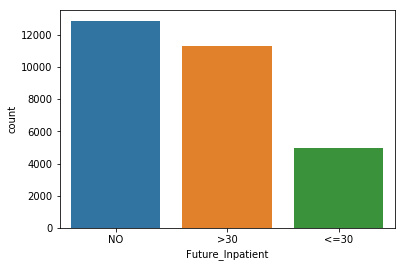

In [33]:
sns.countplot(x = 'Future_Inpatient', data = readmission_ip)

### Age at visit

[Text(0,0.5,'Kernel Density'), Text(0.5,0,'Age at Visit')]

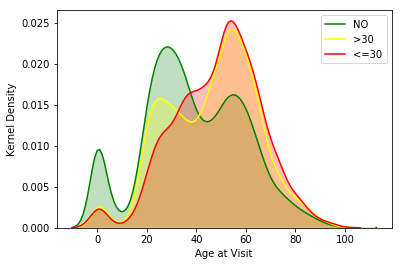

In [313]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == 'NO']['Age_at_visit'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '>30']['Age_at_visit'], color = 'yellow', shade = True, label = '>30')
ax = sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '<=30']['Age_at_visit'], color = 'red', shade = True, label = '<=30')
ax.set(xlabel='Age at Visit', ylabel='Kernel Density')

### Patient city

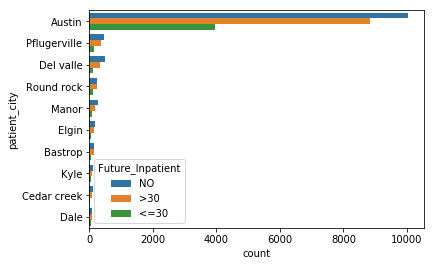

In [35]:
sns.countplot(y = 'patient_city', hue = 'Future_Inpatient', data = readmission_ip, order=readmission_ip.patient_city.value_counts().iloc[:10].index)

### Patient county

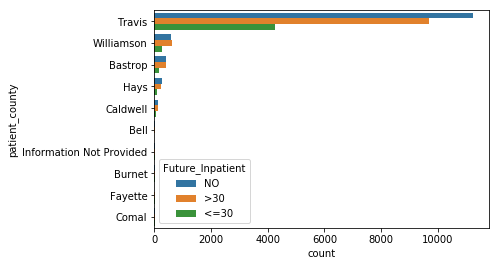

In [36]:
sns.countplot(y = 'patient_county', hue = 'Future_Inpatient', data = readmission_ip, order=readmission_ip.patient_county.value_counts().iloc[:10].index)

### Zipcode

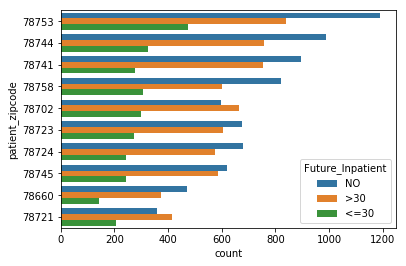

In [37]:
sns.countplot(y = 'patient_zipcode', hue = 'Future_Inpatient', data = readmission_ip, order=readmission_ip.patient_zipcode.value_counts().iloc[:10].index)

### Hospital

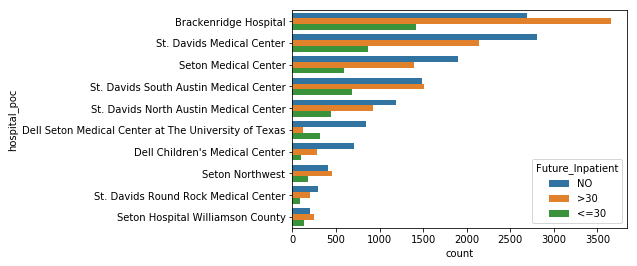

In [38]:
sns.countplot(y = 'hospital_poc', hue = 'Future_Inpatient', data = readmission_ip, order=readmission_ip.hospital_poc.value_counts().iloc[:10].index)

### Income

In [39]:
readmission_ip_income = readmission_ip[readmission_ip['income'] != 'NA']

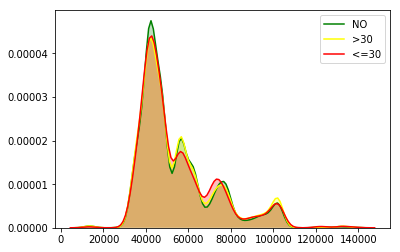

In [40]:
sns.kdeplot(readmission_ip_income[readmission_ip_income['Future_Inpatient'] == 'NO']['income'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip_income[readmission_ip_income['Future_Inpatient'] == '>30']['income'], color = 'yellow', shade = True, label = '>30')
sns.kdeplot(readmission_ip_income[readmission_ip_income['Future_Inpatient'] == '<=30']['income'], color = 'red', shade = True, label = '<=30')

### Education

In [41]:
readmission_ip_education = readmission_ip[readmission_ip['education'] != 'NA']

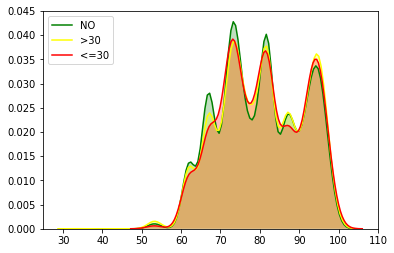

In [42]:
sns.kdeplot(readmission_ip_education[readmission_ip_education['Future_Inpatient'] == 'NO']['education'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip_education[readmission_ip_education['Future_Inpatient'] == '>30']['education'], color = 'yellow', shade = True, label = '>30')
sns.kdeplot(readmission_ip_education[readmission_ip_education['Future_Inpatient'] == '<=30']['education'], color = 'red', shade = True, label = '<=30')

### Poverty

In [43]:
readmission_ip_poverty = readmission_ip[readmission_ip['poverty'] != 'NA']

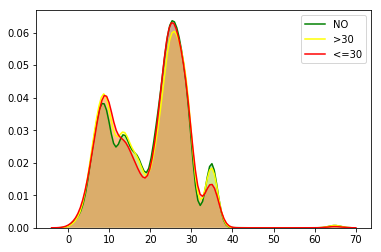

In [44]:
sns.kdeplot(readmission_ip_poverty[readmission_ip_poverty['Future_Inpatient'] == 'NO']['poverty'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip_poverty[readmission_ip_poverty['Future_Inpatient'] == '>30']['poverty'], color = 'yellow', shade = True, label = '>30')
sns.kdeplot(readmission_ip_poverty[readmission_ip_poverty['Future_Inpatient'] == '<=30']['poverty'], color = 'red', shade = True, label = '<=30')

### Payor

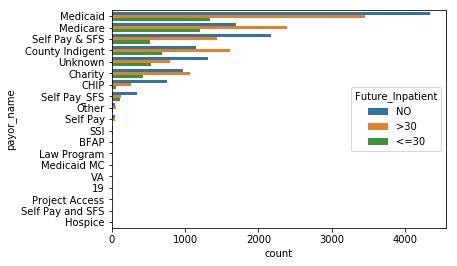

In [45]:
sns.countplot(y = 'payor_name', hue = 'Future_Inpatient', data = readmission_ip, order=readmission_ip.payor_name.value_counts().index)

### Ethnicity

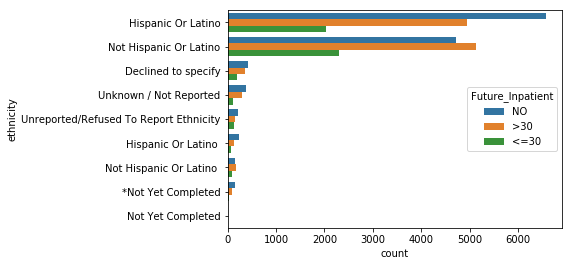

In [46]:
sns.countplot(y = 'ethnicity', hue = 'Future_Inpatient', data = readmission_ip, order=readmission_ip.ethnicity.value_counts().index)

### Language

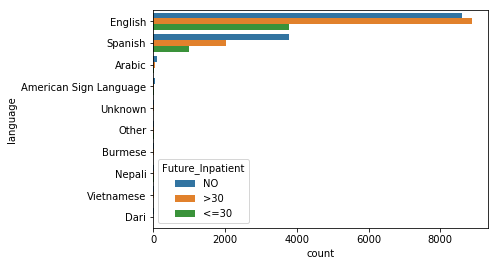

In [47]:
sns.countplot(y = 'language', hue = 'Future_Inpatient', data = readmission_ip, order=readmission_ip.language.value_counts().iloc[:10].index)

### UDS Race

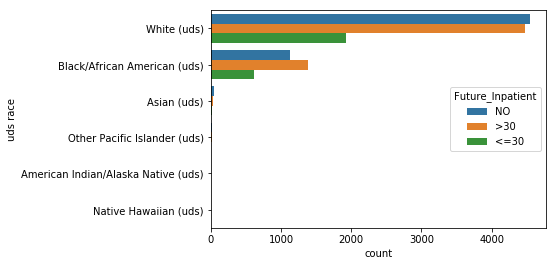

In [48]:
sns.countplot(y = 'uds race', hue = 'Future_Inpatient', data = readmission_ip, order=readmission_ip['uds race'].value_counts().index)

### UDS Homeless

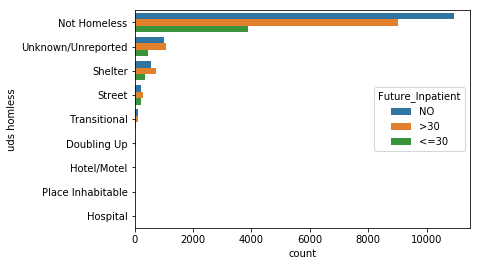

In [49]:
sns.countplot(y = 'uds homless', hue = 'Future_Inpatient', data = readmission_ip, order=readmission_ip['uds homless'].value_counts().index)

In [339]:
homeless = readmission_ip.groupby(['uds homless','Future_Inpatient'])['person_id'].agg(['count']).unstack().reset_index()

In [343]:
homeless = homeless.fillna(0)

In [347]:
homeless.head()

uds homless   count                     total  \
Future_Inpatient                       <=30     >30       NO            
0                       Doubling Up     1.0    33.0     23.0     57.0   
1                          Hospital     0.0     1.0      5.0      6.0   
2                       Hotel/Motel     3.0    14.0     21.0     38.0   
3                      Not Homeless  3251.0  9015.0  10922.0  23188.0   
4                 Place Inhabitable     1.0     5.0      3.0      9.0   

                      <=30       >30        NO  
Future_Inpatient                                
0                 0.017544  0.578947  0.403509  
1                 0.000000  0.166667  0.833333  
2                 0.078947  0.368421  0.552632  
3                 0.140202  0.388779  0.471019  
4                 0.111111  0.555556  0.333333

In [345]:
homeless['total'] = homeless['count']['<=30'] + homeless['count']['>30'] + homeless['count']['NO']

In [346]:
homeless['<=30'] = homeless['count']['<=30']/homeless['total']
homeless['>30'] = homeless['count']['>30']/homeless['total']
homeless['NO'] = homeless['count']['NO']/homeless['total']


In [353]:
homeless = homeless.sort_values(by = 'total', ascending = False)

In [356]:
homeless_df = homeless[['uds homless','<=30','>30','NO']]

In [357]:
homeless_df.set_index('uds homless',inplace = True)

In [362]:
homeless_df.to_csv('homeless.csv')

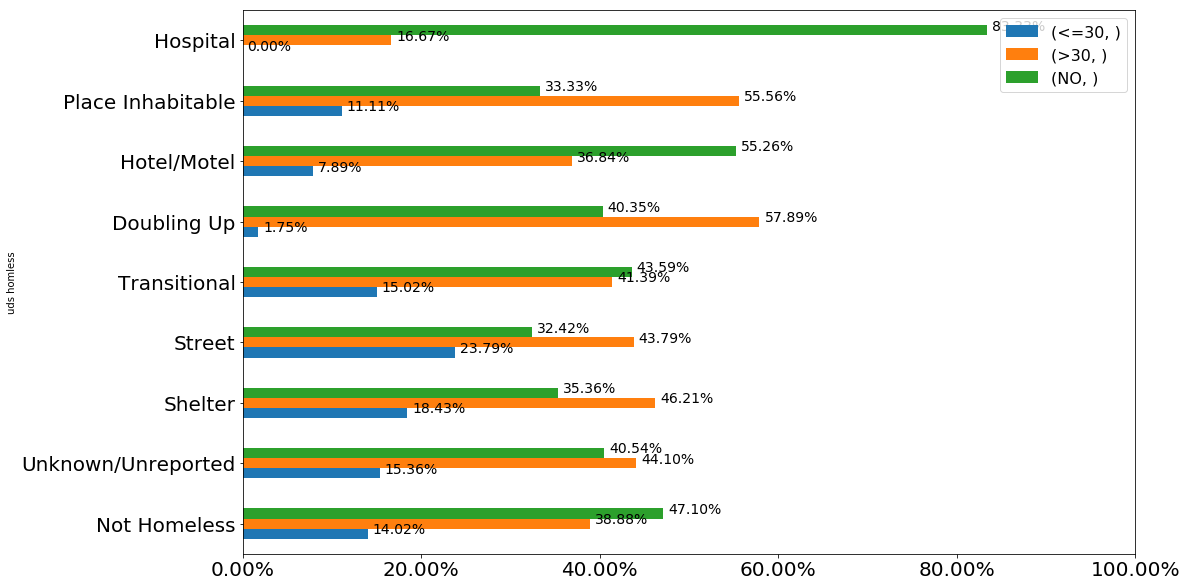

In [359]:
fig, ax = plt.subplots()
homeless_df.plot.barh(figsize=(16, 10),xlim = (0,1), ax = ax)
for p in ax.patches:
        ax.annotate("{:3.2f}%".format(p.get_width()*100), (p.get_x() + p.get_width(), p.get_y() - 0.08), xytext=(5, 10), size = 14, textcoords='offset points')
vals = ax.get_xticks()
ax.set_xticklabels(['{:3.2f}%'.format(x*100) for x in vals]);
ax.tick_params(labelsize=20)
ax.legend(fontsize=16);

### Total LACE score

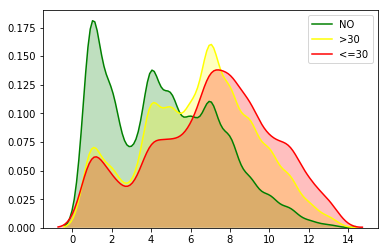

In [50]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == 'NO']['Total LACE score'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '>30']['Total LACE score'], color = 'yellow', shade = True, label = '>30')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '<=30']['Total LACE score'], color = 'red', shade = True, label = '<=30')

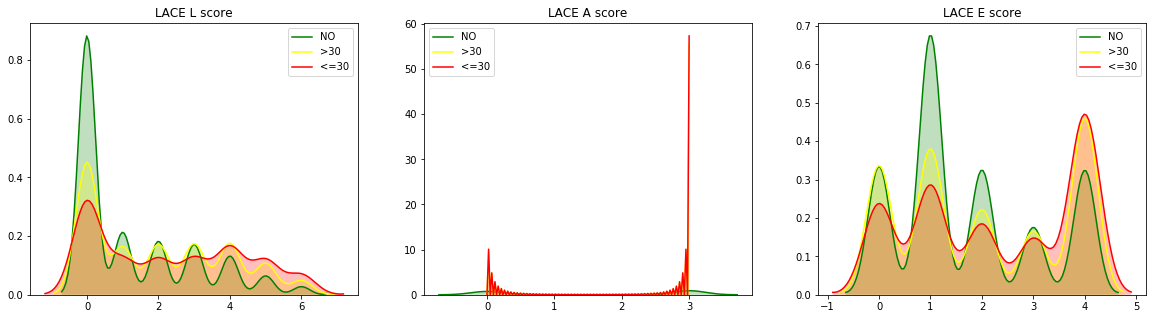

In [51]:
fig, axarr = subplots(nrows = 1, ncols = 3, figsize = (20,5))

lace = ['LACE L score', 'LACE A score', 'LACE E score']

for i,l in enumerate(lace):
    sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == 'NO'][l],color = 'green', shade = 'True', ax = axarr[i], label = 'NO')
    sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '>30'][l],color = 'yellow', shade = 'True', ax = axarr[i], label = '>30')
    sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '<=30'][l],color = 'red', shade = 'True', ax = axarr[i], label = '<=30')
    axarr[i].set_title(l)

### Interval since last visit (ALL)

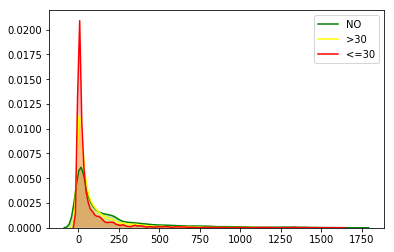

In [52]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == 'NO']['interval_prev_all'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '>30']['interval_prev_all'], color = 'yellow', shade = True, label = '>30')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '<=30']['interval_prev_all'], color = 'red', shade = True, label = '<=30')

### Interval since last visit (IP)

[Text(0,0.5,'Kernel Density'),
 Text(0.5,0,'Time Interval Since Last Inpatient Visit')]

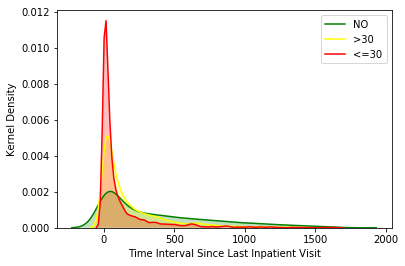

In [315]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == 'NO']['interval_prev'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '>30']['interval_prev'], color = 'yellow', shade = True, label = '>30')
ax = sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '<=30']['interval_prev'], color = 'red', shade = True, label = '<=30')
ax.set(xlabel='Time Interval Since Last Inpatient Visit', ylabel='Kernel Density')

### Interval till next admission (IP)

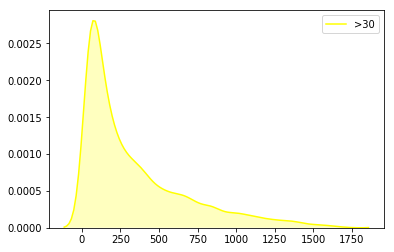

In [54]:
#sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == 'NO']['interval_next'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '>30']['interval_next'], color = 'yellow', shade = True, label = '>30')
#sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '<=30']['interval_next'], color = 'red', shade = True, label = '<=30')

### Past ER visits (last 12 months)

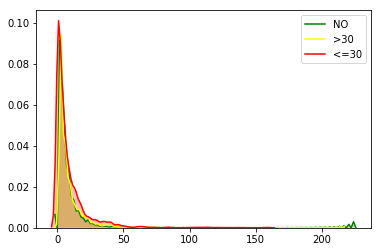

In [55]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == 'NO']['past_visits_ER'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '>30']['past_visits_ER'], color = 'yellow', shade = True, label = '>30')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '<=30']['past_visits_ER'], color = 'red', shade = True, label = '<=30')

### Past Inpatient visits (last 12 months)

[Text(0,0.5,'Kernel Density'), Text(0.5,0,'Past Inpatients Visits')]

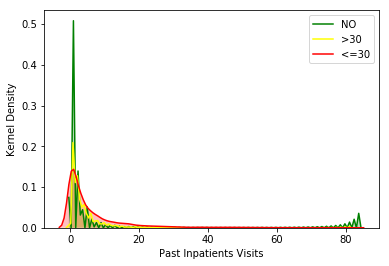

In [314]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == 'NO']['past_visits_IP'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '>30']['past_visits_IP'], color = 'yellow', shade = True, label = '>30')
ax = sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '<=30']['past_visits_IP'], color = 'red', shade = True, label = '<=30')
ax.set(xlabel='Past Inpatients Visits', ylabel='Kernel Density')

### Transfer in from ER

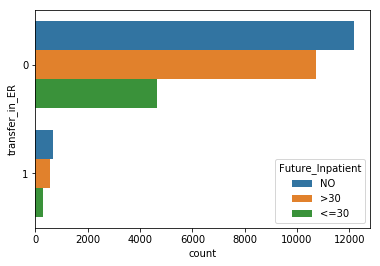

In [57]:
sns.countplot(y = 'transfer_in_ER', hue = 'Future_Inpatient', data = readmission_ip)

### Transfer in from IP

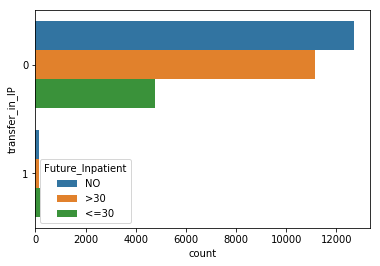

In [58]:
sns.countplot(y = 'transfer_in_IP', hue = 'Future_Inpatient', data = readmission_ip)

### CCS10 Category

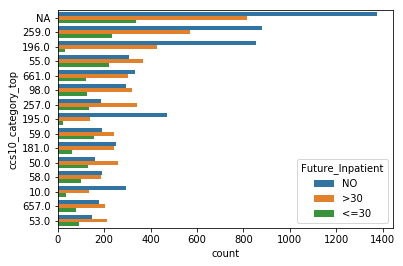

In [59]:
sns.countplot(y = 'ccs10_category_top', hue = 'Future_Inpatient', data = readmission_ip, order=readmission_ip['ccs10_category_top'].value_counts().iloc[:15].index)

## Classifier

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, brier_score_loss, average_precision_score, classification_report 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, Imputer, label_binarize, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from itertools import cycle
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [67]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import optimizers
from keras import utils
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers.normalization import BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import Nadam
from keras.utils import plot_model
from keras import regularizers
from keras.layers import BatchNormalization


Using TensorFlow backend.


In [61]:
readmission_ip.dtypes

person_id                                 object
Age_at_visit                               int64
patient_city                              object
patient_county                            object
patient_zipcode                            int64
hospital_poc                              object
Hospital_visit_date               datetime64[ns]
discharge_date                    datetime64[ns]
encounter_type                            object
payor_name                                object
last community care location              object
last community care visit date    datetime64[ns]
ethnicity                                 object
language                                  object
uds ethnicity                             object
uds race                                  object
uds homless                               object
LACE L score                               int64
LACE A score                               int64
LACE E score                               int64
Total LACE score    

### Exclude Transfer Admission (TA)

In [36]:
readmission_ip = readmission_ip[readmission_ip.transfer_out_IP == 0]

### Select features

In [37]:
readmission_ip_model = readmission_ip[['Age_at_visit','patient_city','patient_county','hospital_poc','payor_name','last community care location','ethnicity','language','uds ethnicity','uds race','uds homless','LACE L score','LACE A score','LACE E score','Total LACE score','transfer_in_ER','transfer_in_IP','interval_prev','interval_prev_all','past_visits_ER','past_visits_IP','income','education','poverty','ccs10_category_top','Future_Inpatient']]

In [38]:
readmission_ip_model = readmission_ip_model[readmission_ip_model.patient_city == 'Austin']

In [39]:
readmission_ip_model.dtypes

Age_at_visit                      int64
patient_city                     object
patient_county                   object
hospital_poc                     object
payor_name                       object
last community care location     object
ethnicity                        object
language                         object
uds ethnicity                    object
uds race                         object
uds homless                      object
LACE L score                      int64
LACE A score                      int64
LACE E score                      int64
Total LACE score                  int64
transfer_in_ER                    int64
transfer_in_IP                    int64
interval_prev                   float64
interval_prev_all               float64
past_visits_ER                  float64
past_visits_IP                  float64
income                           object
education                        object
poverty                          object
ccs10_category_top               object


In [66]:
readmission_ip_model['income'] = readmission_ip_model.income.apply(lambda x: np.nan if x == 'NA' else x)
readmission_ip_model['education'] = readmission_ip_model.education.apply(lambda x: np.nan if x == 'NA' else x)
readmission_ip_model['poverty'] = readmission_ip_model.poverty.apply(lambda x: np.nan if x == 'NA' else x)

In [67]:
def get_transfer(transfer):
    if transfer == 0:
        return 'No'
    else:
        return 'Yes'

In [68]:
readmission_ip_model['transfer_in_ER'] = readmission_ip_model.transfer_in_ER.apply(get_transfer)
readmission_ip_model['transfer_in_IP'] = readmission_ip_model.transfer_in_ER.apply(get_transfer)

In [69]:
#readmission_ip_model['Age_at_visit'] = readmission_ip_model['Age_at_visit'].apply(lambda x: np.nan if x == 0 else x)

In [70]:
num = readmission_ip_model.select_dtypes(include=[int64, float64]).columns.values.tolist()
cat = readmission_ip_model.select_dtypes(include=[object]).drop('Future_Inpatient',axis=1).columns.values.tolist()

In [71]:
num

['Age_at_visit',
 'LACE L score',
 'LACE A score',
 'LACE E score',
 'Total LACE score',
 'interval_prev',
 'interval_prev_all',
 'past_visits_ER',
 'past_visits_IP',
 'income',
 'education',
 'poverty']

In [72]:
cat

['patient_city',
 'patient_county',
 'hospital_poc',
 'payor_name',
 'last community care location',
 'ethnicity',
 'language',
 'uds ethnicity',
 'uds race',
 'uds homless',
 'transfer_in_ER',
 'transfer_in_IP',
 'ccs10_category_top']

In [73]:
readmission_ip_model[num].apply(lambda x: x.isnull().sum())

Age_at_visit            0
LACE L score            0
LACE A score            0
LACE E score            0
Total LACE score        0
interval_prev        9856
interval_prev_all    3092
past_visits_ER          0
past_visits_IP          0
income                364
education             364
poverty               364
dtype: int64

### Feature transformation and Train-test split

In [74]:
imputer = Imputer()
X_num_wnull = imputer.fit_transform(readmission_ip_model[['interval_prev','interval_prev_all','income','education','poverty']])

In [75]:
encoder = OneHotEncoder()
le = LabelEncoder()

X_num_wonull = np.array(readmission_ip_model[['Age_at_visit','LACE L score', 'LACE A score', 'LACE E score', 'Total LACE score','past_visits_ER','past_visits_IP']])
X_cat = readmission_ip_model[cat].astype(str).apply(le.fit_transform)
X_cat = encoder.fit_transform(X_cat).toarray()
#X_nl = np.concatenate((X_num_wonull, X_num_wnull), axis = 1)
X_nl = np.concatenate((X_num_wonull, X_num_wnull, X_cat), axis = 1)

y = readmission_ip_model.Future_Inpatient.apply(lambda x: 0 if x =='NO' else 1)

X_train, X_test, y_train, y_test = train_test_split(X_nl, y, test_size=0.3, random_state=24)

X_train_num, X_train_cat = X_train[:,:11], X_train[:,11:]
X_test_num, X_test_cat = X_test[:,:11], X_test[:,11:]

In [76]:
#get names for cat features
cat_list = []
for c in cat:
    values = sorted(set(readmission_ip_model[c].astype(str).values.tolist()))
    for v in values:
        cat_list.append('{}_{}'.format(c,v))   

#col_names =['Age_at_visit','LACE L score', 'LACE A score', 'LACE E score', 'Total LACE score','past_visits_ER','past_visits_IP'] + ['interval','income']
col_names =['Age_at_visit','LACE L score', 'LACE A score', 'LACE E score', 'Total LACE score','past_visits_ER','past_visits_IP'] + ['interval_prev','interval_prev_all','income','education','poverty'] + cat_list
X_features_nl = pd.DataFrame(X_nl, columns=col_names)
X_features_nl_train = pd.DataFrame(X_train, columns=col_names)
X_features_nl_test = pd.DataFrame(X_test, columns=col_names)

In [77]:
X_features_nl.shape

(22167, 423)

In [78]:
X_features_nl_train.shape

(15516, 423)

In [79]:
X_features_nl.head()

,Age_at_visit,LACE L score,LACE A score,LACE E score,Total LACE score,past_visits_ER,past_visits_IP,interval_prev,interval_prev_all,income,...,ccs10_category_top_91.0,ccs10_category_top_92.0,ccs10_category_top_93.0,ccs10_category_top_94.0,ccs10_category_top_95.0,ccs10_category_top_96.0,ccs10_category_top_97.0,ccs10_category_top_98.0,ccs10_category_top_99.0,ccs10_category_top_NA
0,36.0,0.0,0.0,1.0,1.0,0.0,0.0,237.644464,132.362726,56819.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.0,0.0,3.0,2.0,5.0,0.0,0.0,237.644464,132.362726,43871.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53.0,1.0,3.0,4.0,8.0,4.0,0.0,237.644464,4.000000,47244.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,23.0,3.0,3.0,1.0,7.0,3.0,0.0,237.644464,180.000000,34950.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24.0,0.0,3.0,1.0,4.0,4.0,1.0,393.000000,201.000000,34950.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Baseline

In [80]:
baseline = y_test.value_counts()[1]*1.0/len(y_test)
baseline

0.54833859569989474

### Tree-based model

### Random Forest

In [82]:
clf_rf = RandomForestClassifier()
n_estimators = [10, 50, 100, 200, 500]
max_features = ['sqrt', 'log2']
param_grid = dict(n_estimators=n_estimators, max_features = max_features)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
grid_search_rf = GridSearchCV(clf_rf, param_grid, n_jobs=-1,scoring="roc_auc", cv=kfold)
grid_search_rf.fit(X_train, y_train)
result_rf = grid_search_rf.cv_results_

In [83]:
mean_test_score_rf = result_rf['mean_test_score']

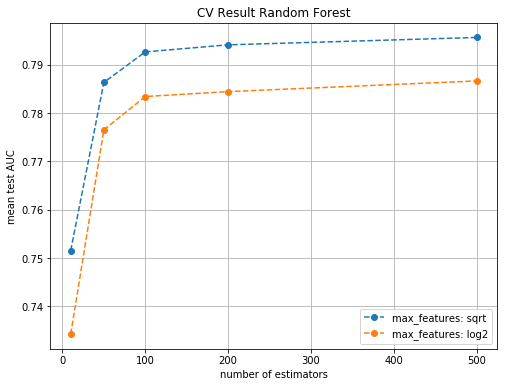

In [84]:
mean_test_score_rf = mean_test_score_rf.reshape(len(max_features),len(n_estimators))
plt.figure(figsize=(8,6))
for i, score in enumerate(mean_test_score_rf):
    plt.plot(n_estimators,mean_test_score_rf[i,], '--',marker = 'o', label = 'max_features: %s'%(max_features[i]))
plt.xlabel('number of estimators')
plt.ylabel('mean test AUC')
plt.title('CV Result Random Forest')
plt.legend()
plt.grid(True)

In [85]:
clf_rf = RandomForestClassifier(n_estimators=500, max_features = 'sqrt')

start = time.time()
clf_rf.fit(X_train,y_train)
print ('Random Forest model fitting time: {}s'.format(time.time()-start))

y_pred_rf = clf_rf.predict(X_test)
y_pred_prob_rf = clf_rf.predict_proba(X_test)[:,1]

Random Forest model fitting time: 74.34936332702637s


In [86]:
accuracy_score(y_pred_rf, y_test)

0.72289881220869046

In [87]:
print(classification_report(y_test, y_pred_rf))

             precision    recall  f1-score   support

          0       0.70      0.68      0.69      3004
          1       0.74      0.76      0.75      3647

avg / total       0.72      0.72      0.72      6651



In [88]:
fimp_rf = zip(X_features_nl.columns.values.tolist(),clf_rf.feature_importances_.tolist())

In [89]:
sorted(fimp_rf, key = lambda x: x[1], reverse=True)[:20]

[('interval_prev_all', 0.06887751713970658),
 ('interval_prev', 0.06572307948832112),
 ('Age_at_visit', 0.06445266292755361),
 ('Total LACE score', 0.05551002940784705),
 ('past_visits_ER', 0.04640304204778711),
 ('past_visits_IP', 0.04494717658281309),
 ('education', 0.035294112916697144),
 ('income', 0.03512306607406906),
 ('poverty', 0.034469151504039765),
 ('LACE L score', 0.032136517380724546),
 ('LACE E score', 0.029287536214340635),
 ('LACE A score', 0.028031400116769432),
 ('hospital_poc_Brackenridge Hospital', 0.015090695416397163),
 ('hospital_poc_Dell Seton Medical Center at The University of Texas',
  0.010888633322488721),
 ('payor_name_Medicaid', 0.008930416323626063),
 ('language_English', 0.00873603769342759),
 ('hospital_poc_St. Davids Medical Center', 0.008509780269862844),
 ('ccs10_category_top_NA', 0.008317109398447198),
 ('last community care location_CUC North Central', 0.008015321602337842),
 ('ethnicity_Hispanic Or Latino', 0.007843058022699372)]

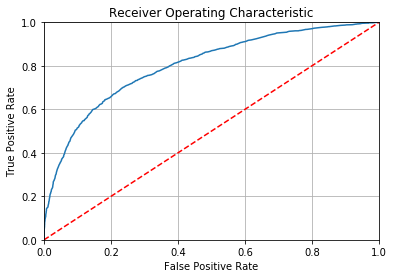

In [90]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid(True)

In [91]:
roc_auc_rf

0.80262223259947341

### XGBoost 

In [92]:
clf_xgb = XGBClassifier()
n_estimators = [10, 50, 100, 200, 500]
learning_rate = [0.001, 0.01, 0.1]
reg_lambda = [0.001, 0.01, 0.1, 1, 10]
# sub_sample = [0.1, 0.5, 1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators,reg_lambda = reg_lambda)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
grid_search_xgb = GridSearchCV(clf_xgb, param_grid, n_jobs = -1, scoring="roc_auc", cv=kfold)
grid_search_xgb.fit(X_train, y_train)
result_xgb = grid_search_xgb.cv_results_

In [93]:
mean_test_score_xgb = result_xgb['mean_test_score']

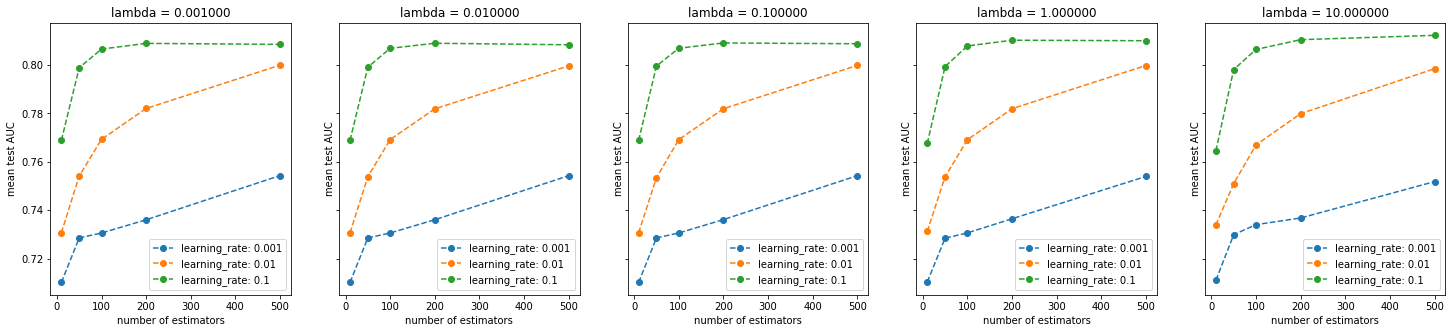

In [94]:
mean_test_score_xgb = np.swapaxes(np.swapaxes(mean_test_score_xgb.reshape(len(learning_rate), len(n_estimators), len(reg_lambda)),1,2),0,1)
fig, (ax1, ax2, ax3, ax4, ax5) = subplots(nrows=1,ncols=5,figsize=(25, 5), sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5]

for i, score in enumerate(mean_test_score_xgb):
    for j,s in enumerate(score):
        ax[i].plot(n_estimators, score[j,], '--',marker = 'o', label = 'learning_rate: %s'%(learning_rate[j]))
    ax[i].set_xlabel('number of estimators')
    ax[i].set_ylabel('mean test AUC')
    ax[i].set_title('lambda = %f'%reg_lambda[i])
    ax[i].legend()

In [95]:
clf_xgb = XGBClassifier(n_estimators=500, learning_rate = 0.1, reg_lambda = 10)
start = time.time()
clf_xgb.fit(X_train,y_train)
print ('XGBoost model fitting time: {}s'.format(time.time()-start))

y_pred_xgb = clf_xgb.predict(X_test)
y_pred_prob_xgb = clf_xgb.predict_proba(X_test)[:,1]

XGBoost model fitting time: 34.542590379714966s


In [96]:
fimp_xgb = zip(X_features_nl.columns.values.tolist(),clf_xgb.feature_importances_.tolist())

#### Get top 20 features

In [97]:
fimp_xgb_top = sorted(fimp_xgb, key = lambda x: x[1], reverse=True)[:20]

In [98]:
fimp_xgb_top

[('interval_prev', 0.08010253310203552),
 ('past_visits_ER', 0.07497596740722656),
 ('Age_at_visit', 0.0730535089969635),
 ('interval_prev_all', 0.07209227979183197),
 ('past_visits_IP', 0.05799423158168793),
 ('Total LACE score', 0.046779878437519073),
 ('LACE E score', 0.044216595590114594),
 ('income', 0.029477732256054878),
 ('LACE A score', 0.027234859764575958),
 ('education', 0.020826658234000206),
 ('hospital_poc_Brackenridge Hospital', 0.020185837522149086),
 ('poverty', 0.016981735825538635),
 ('payor_name_Unknown', 0.014418455772101879),
 ('hospital_poc_Dell Seton Medical Center at The University of Texas',
  0.013457225635647774),
 ('LACE L score', 0.013136815279722214),
 ('uds homless_Not Homeless', 0.012816404923796654),
 ('ccs10_category_top_176.0', 0.012175585143268108),
 ('ethnicity_Hispanic Or Latino', 0.010573534294962883),
 ('payor_name_Self Pay_SFS', 0.009612304158508778),
 ('ethnicity_Not Hispanic Or Latino', 0.009612304158508778)]

In [99]:
features_top = [f for (f,imp) in fimp_xgb_top]

In [100]:
X_train_top = np.array(X_features_nl_train.loc[:,features_top])

In [101]:
X_test_top = np.array(X_features_nl_test.loc[:,features_top])

In [102]:
accuracy_score(y_pred_xgb, y_test)

0.73898661855360093

In [103]:
print(classification_report(y_test, y_pred_xgb))

             precision    recall  f1-score   support

          0       0.71      0.72      0.71      3004
          1       0.76      0.76      0.76      3647

avg / total       0.74      0.74      0.74      6651



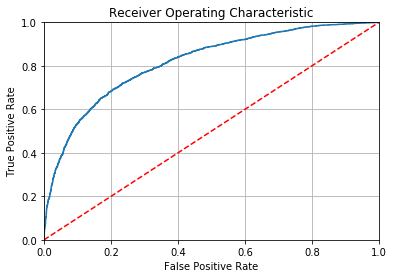

In [104]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid(True)

In [105]:
roc_auc_xgb

0.81710255989911273

### TOP FEATURES FROM XGBOOST

In [106]:
#X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size=0.3, random_state=24)
clf_xgb = XGBClassifier(n_estimators=500, learning_rate = 0.1, reg_lambda = 10)
start = time.time()
clf_xgb.fit(X_train_top,y_train)
print ('XGBoost model fitting time: {}s'.format(time.time()-start))

y_pred_xgb = clf_xgb.predict(X_test_top)
y_pred_prob_xgb = clf_xgb.predict_proba(X_test_top)[:,1]

XGBoost model fitting time: 6.727514982223511s


In [107]:
accuracy_score(y_pred_xgb, y_test)

0.73432566531348664

In [108]:
print(classification_report(y_test, y_pred_xgb))

             precision    recall  f1-score   support

          0       0.70      0.72      0.71      3004
          1       0.77      0.74      0.75      3647

avg / total       0.74      0.73      0.73      6651



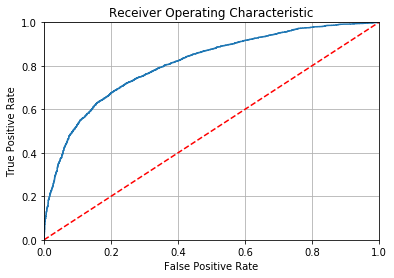

In [109]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid(True)

In [110]:
roc_auc_xgb

0.81028471497832888

### <font color='green'>L</font> <font color='yellow'>I</font> <font color='green'>M</font> <font color='green'>E</font>

In [111]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import lime.lime_tabular
from __future__ import print_function

In [112]:
predict_fn_rf = lambda x: clf_rf.predict_proba(x).astype(float)

In [153]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=col_names, categorical_features=range(11,423), categorical_names=cat_list, class_names = ['No','Yes'])

In [120]:
predict_fn_xgb = lambda x: clf_xgb.predict_proba(x).astype(float)

In [148]:
cate_names = ['hospital_poc_Brackenridge Hospital','payor_name_Unknown',
              'hospital_poc_Dell Seton Medical Center at The University of Texas','uds homless_Not Homeless',
              'ccs10_category_top_176.0','ethnicity_Hispanic Or Latino',
              'payor_name_Self Pay_SFS','ethnicity_Not Hispanic Or Latino']

In [154]:
explainer2 = lime.lime_tabular.LimeTabularExplainer(X_train_top, feature_names=features_top, categorical_features= [10,12,13,15,16,17,18,19], categorical_names=cate_names, class_names = ['No','Yes'])

In [172]:
obs = 44

In [173]:
exp = explainer.explain_instance(X_test[obs], predict_fn_rf, num_features=10,)
exp.show_in_notebook()

In [221]:
exp = explainer2.explain_instance(X_test_top[obs], predict_fn_xgb, num_features=10)
exp.as_list()

[('ccs10_category_top_176.0=0', 0.3001992811335063),
 ('hospital_poc_Dell Seton Medical Center at The University of Texas=0',
  0.25840434651993399),
 ('payor_name_Self Pay_SFS=0', 0.17415169747628809),
 ('past_visits_IP > 3.00', 0.16875018324494684),
 ('0.00 < LACE A score <= 3.00', 0.14611765362552279),
 ('past_visits_ER > 7.00', -0.14356019478698617),
 ('hospital_poc_Brackenridge Hospital=0', -0.14248656542299734),
 ('payor_name_Unknown=0', 0.13135201311138622),
 ('Total LACE score > 8.00', 0.12896908856516992),
 ('45.00 < Age_at_visit <= 57.00', 0.072665364277710337)]

### Logistic Regression

In [175]:
readmission_ip_model.interval_prev = readmission_ip_model.interval_prev.apply(lambda x:np.log10(x+0.1))
readmission_ip_model.interval_prev_all = readmission_ip_model.interval_prev_all.apply(lambda x:np.log10(x+0.1))
readmission_ip_model.past_visits_IP = readmission_ip_model.past_visits_IP.apply(lambda x:np.log10(x+0.1))
readmission_ip_model.past_visits_ER = readmission_ip_model.past_visits_ER.apply(lambda x:np.log10(x+0.1))

In [176]:
imputer = Imputer()
X_num_wnull = imputer.fit_transform(readmission_ip_model[['interval_prev','interval_prev_all','income','education','poverty']])

In [177]:
encoder = OneHotEncoder()
le = LabelEncoder()

X_num_wonull = np.array(readmission_ip_model[['Age_at_visit','LACE L score', 'LACE A score', 'LACE E score', 'Total LACE score','past_visits_ER','past_visits_IP']])
X_cat = readmission_ip_model[cat].astype(str).apply(le.fit_transform)
X_cat = encoder.fit_transform(X_cat).toarray()
X_l = np.concatenate((X_num_wonull, X_num_wnull, X_cat), axis = 1)

y = readmission_ip_model.Future_Inpatient.apply(lambda x: 0 if x =='NO' else 1)

X_train, X_test, y_train, y_test = train_test_split(X_l, y, test_size=0.3, random_state=24)

X_train_num, X_train_cat = X_train[:,:11], X_train[:,11:]
X_test_num, X_test_cat = X_test[:,:11], X_test[:,11:]

In [178]:
cat_list = []
for c in cat:
    values = sorted(set(readmission_ip_model[c].astype(str).values.tolist()))
    for v in values:
        cat_list.append('{}_{}'.format(c,v))   

col_names =['Age_at_visit','LACE L score', 'LACE A score', 'LACE E score', 'Total LACE score','past_visits_ER','past_visits_IP'] + ['interval_prev','interval_prev_all','income','education','poverty'] + cat_list
X_features_l = pd.DataFrame(X_l, columns=col_names)

In [179]:
X_features_l.shape

(22167, 423)

In [180]:
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train)
X_test_lr = scaler.transform(X_test)

In [181]:
X_train_lr.shape

(15516, 423)

In [182]:
clf_lr = LogisticRegression()
C = [0.001, 0.01, 0.1, 1, 10]
penalty = ['l2','l1']
param_grid = dict(C = C, penalty = penalty)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
grid_search_lr = GridSearchCV(clf_lr, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_search_lr.fit(X_train_lr, y_train)
result_lr = grid_search_lr.cv_results_

In [183]:
mean_test_score_lr = np.transpose(result_lr['mean_test_score'].reshape(len(C), len(penalty)))

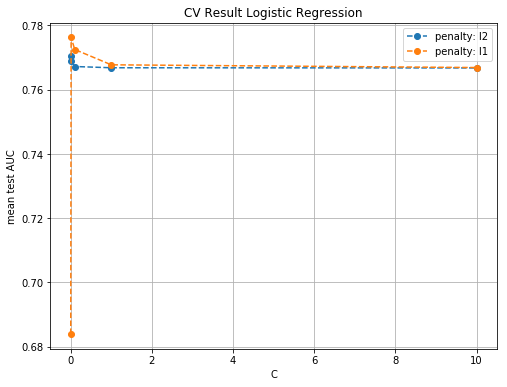

In [184]:
plt.figure(figsize=(8,6))
for i, score in enumerate(mean_test_score_lr):
    plt.plot(C, mean_test_score_lr[i,], '--',marker = 'o', label = 'penalty: %s'%(penalty[i]))
plt.xlabel('C')
plt.ylabel('mean test AUC')
plt.title('CV Result Logistic Regression')
plt.legend()
plt.grid(True)

In [185]:
clf_lr = LogisticRegression(penalty='l1', C = 0.01)
clf_lr.fit(X_train_lr,y_train)

y_pred_lr = clf_lr.predict(X_test_lr)
y_pred_prob_lr = clf_lr.predict_proba(X_test_lr)[:,1]

In [186]:
accuracy_score(y_pred_lr, y_test)

0.71508043903172458

In [187]:
print(classification_report(y_test, y_pred_lr))

             precision    recall  f1-score   support

          0       0.69      0.68      0.68      3004
          1       0.74      0.74      0.74      3647

avg / total       0.71      0.72      0.71      6651



In [188]:
lr_lasso = LogisticRegression(penalty='l1', C = 0.001) #high C to shrink coefs of variables to zero
lr_lasso.fit(X_train, y_train)
lr_coef = zip(X_features_l.columns.values.tolist(),lr_lasso.coef_[0].tolist())

In [189]:
pd.DataFrame(sorted([x for x in lr_coef if x[1] != 0], key = lambda x: x[1], reverse=True))

,0,1
0,Total LACE score,0.154725
1,Age_at_visit,0.014780
2,income,-0.000007
3,education,-0.006335
4,poverty,-0.019042


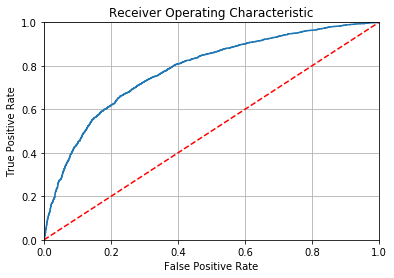

In [190]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_prob_lr)
    
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid(True)

In [191]:
roc_auc_lr

0.78178154381124942

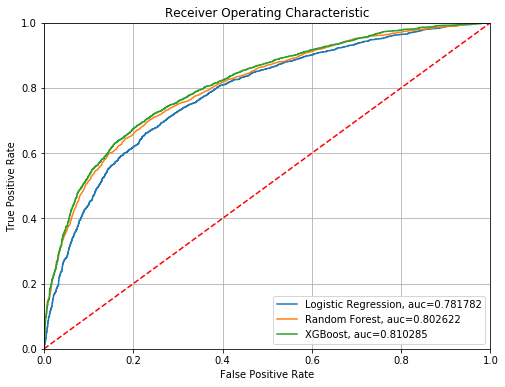

In [192]:
fpr = dict()
tpr = dict()
roc_auc = dict()
model = ['Logistic Regression', 'Random Forest', 'XGBoost']
y_pred_prob = [y_pred_prob_lr, y_pred_prob_rf, y_pred_prob_xgb]

plt.figure(figsize=(8,6))

for i in range(len(model)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob[i])
    roc_auc[i] = roc_auc_score(y_test, y_pred_prob[i])
    
for i in range(len(model)):
    plt.plot(fpr[i], tpr[i], label = '%s, auc=%f'%(model[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)

## <font color='green'>IP to IP (90-day Readmission)</font> 

In [46]:
def readmission_90(interval):
    if pd.isnull(interval):
        return 'NO'
    elif interval > 90:
        return '>90'
    else:
        return '<=90'
readmission_ip['Future_Inpatient_90'] = readmission_ip.interval_next.apply(readmission_90)

In [47]:
readmission_ip.dtypes

person_id                                 object
Age_at_visit                               int64
patient_city                              object
patient_county                            object
patient_zipcode                            int64
hospital_poc                              object
Hospital_visit_date               datetime64[ns]
discharge_date                    datetime64[ns]
encounter_type                            object
payor_name                                object
last community care location              object
last community care visit date    datetime64[ns]
ethnicity                                 object
language                                  object
uds ethnicity                             object
uds race                                  object
uds homless                               object
LACE L score                               int64
LACE A score                               int64
LACE E score                               int64
Total LACE score    

In [35]:
#readmission_ip.to_csv('data/readmission_ip_90.csv')

## EDA

### Readmission

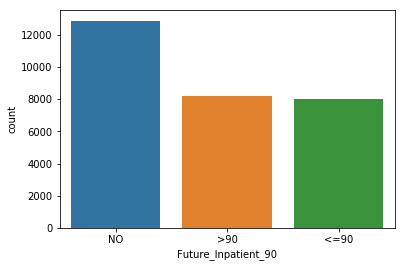

In [36]:
sns.countplot(x = 'Future_Inpatient_90', data = readmission_ip)

### Age at visit

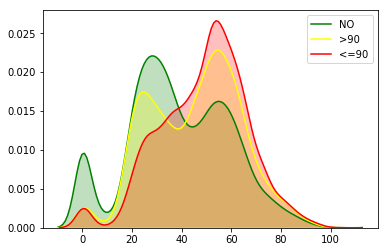

In [37]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == 'NO']['Age_at_visit'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '>90']['Age_at_visit'], color = 'yellow', shade = True, label = '>90')
ax = sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '<=90']['Age_at_visit'], color = 'red', shade = True, label = '<=90')

### Patient city

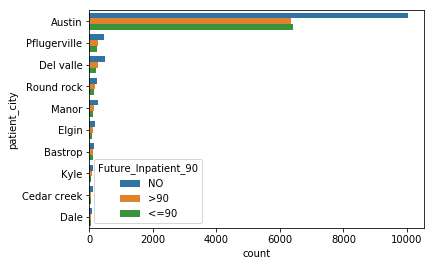

In [38]:
sns.countplot(y = 'patient_city', hue = 'Future_Inpatient_90', data = readmission_ip, order=readmission_ip.patient_city.value_counts().iloc[:10].index)

### Patient county

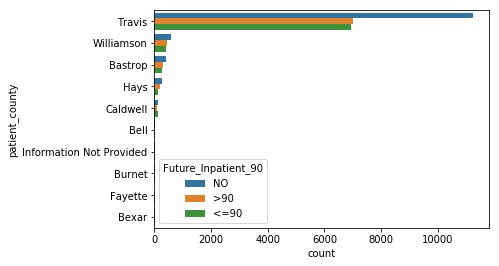

In [39]:
sns.countplot(y = 'patient_county', hue = 'Future_Inpatient_90', data = readmission_ip, order=readmission_ip.patient_county.value_counts().iloc[:10].index)

### Zipcode

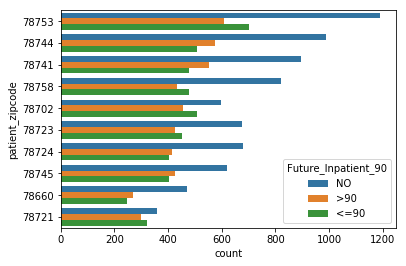

In [40]:
sns.countplot(y = 'patient_zipcode', hue = 'Future_Inpatient_90', data = readmission_ip, order=readmission_ip.patient_zipcode.value_counts().iloc[:10].index)

### Hospital

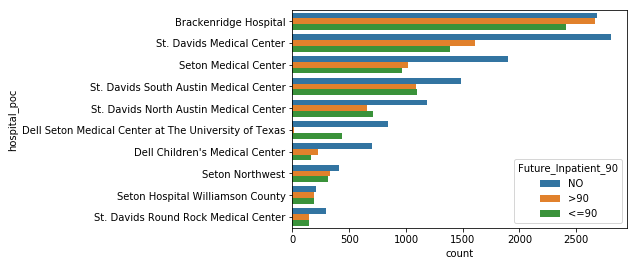

In [41]:
sns.countplot(y = 'hospital_poc', hue = 'Future_Inpatient_90', data = readmission_ip, order=readmission_ip.hospital_poc.value_counts().iloc[:10].index)

### Income

In [42]:
readmission_ip_income = readmission_ip[readmission_ip['income'] != 'NA']

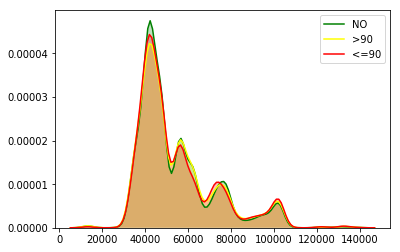

In [43]:
sns.kdeplot(readmission_ip_income[readmission_ip_income['Future_Inpatient_90'] == 'NO']['income'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip_income[readmission_ip_income['Future_Inpatient_90'] == '>90']['income'], color = 'yellow', shade = True, label = '>90')
sns.kdeplot(readmission_ip_income[readmission_ip_income['Future_Inpatient_90'] == '<=90']['income'], color = 'red', shade = True, label = '<=90')

### Education

In [44]:
readmission_ip_education = readmission_ip[readmission_ip['education'] != 'NA']

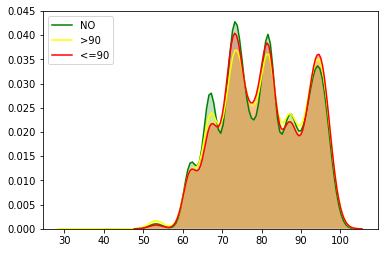

In [45]:
sns.kdeplot(readmission_ip_education[readmission_ip_education['Future_Inpatient_90'] == 'NO']['education'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip_education[readmission_ip_education['Future_Inpatient_90'] == '>90']['education'], color = 'yellow', shade = True, label = '>90')
sns.kdeplot(readmission_ip_education[readmission_ip_education['Future_Inpatient_90'] == '<=90']['education'], color = 'red', shade = True, label = '<=90')

### Poverty

In [46]:
readmission_ip_poverty = readmission_ip[readmission_ip['poverty'] != 'NA']

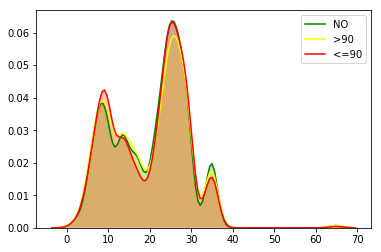

In [47]:
sns.kdeplot(readmission_ip_poverty[readmission_ip_poverty['Future_Inpatient_90'] == 'NO']['poverty'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip_poverty[readmission_ip_poverty['Future_Inpatient_90'] == '>90']['poverty'], color = 'yellow', shade = True, label = '>90')
sns.kdeplot(readmission_ip_poverty[readmission_ip_poverty['Future_Inpatient_90'] == '<=90']['poverty'], color = 'red', shade = True, label = '<=90')

### Payor

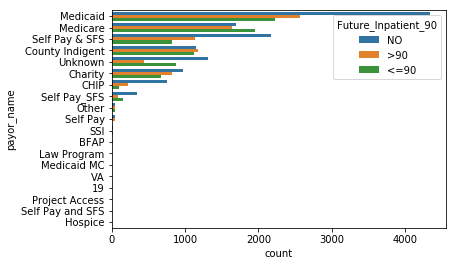

In [48]:
sns.countplot(y = 'payor_name', hue = 'Future_Inpatient_90', data = readmission_ip, order=readmission_ip.payor_name.value_counts().index)

### Ethnicity

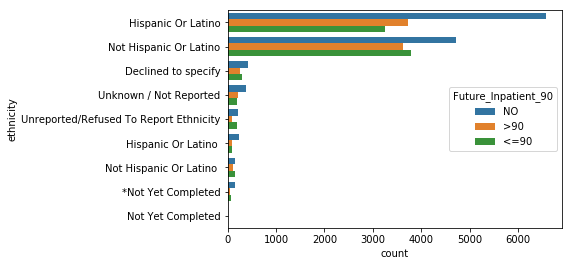

In [49]:
sns.countplot(y = 'ethnicity', hue = 'Future_Inpatient_90', data = readmission_ip, order=readmission_ip.ethnicity.value_counts().index)

### Language

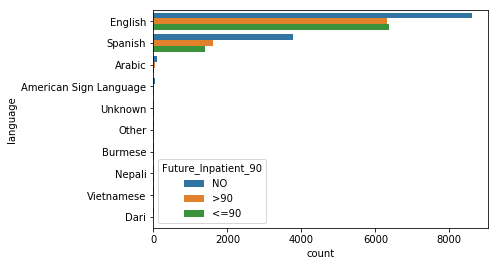

In [50]:
sns.countplot(y = 'language', hue = 'Future_Inpatient_90', data = readmission_ip, order=readmission_ip.language.value_counts().iloc[:10].index)

### UDS Race

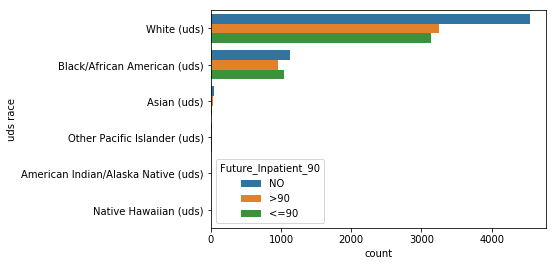

In [51]:
sns.countplot(y = 'uds race', hue = 'Future_Inpatient_90', data = readmission_ip, order=readmission_ip['uds race'].value_counts().index)

### UDS Homeless

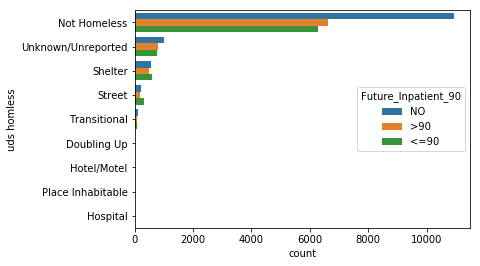

In [52]:
sns.countplot(y = 'uds homless', hue = 'Future_Inpatient_90', data = readmission_ip, order=readmission_ip['uds homless'].value_counts().index)

### Total LACE score

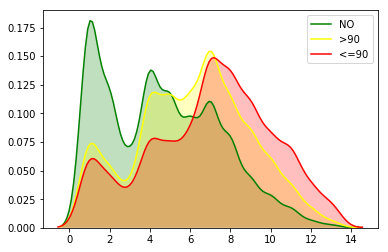

In [53]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == 'NO']['Total LACE score'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '>90']['Total LACE score'], color = 'yellow', shade = True, label = '>90')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '<=90']['Total LACE score'], color = 'red', shade = True, label = '<=90')

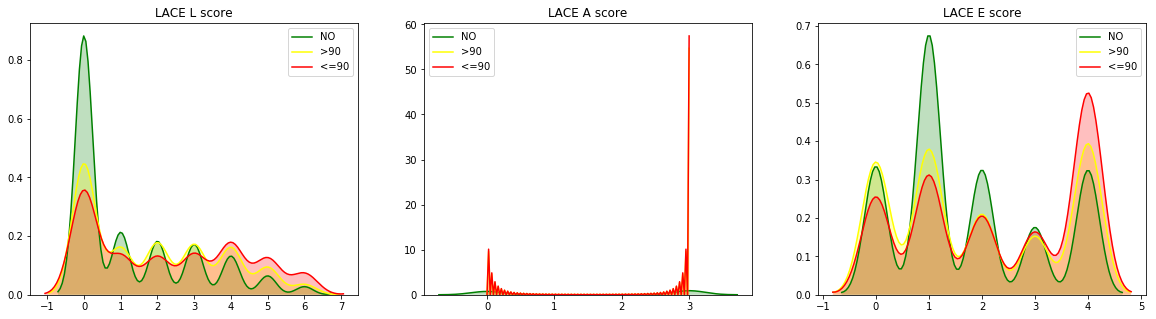

In [54]:
fig, axarr = subplots(nrows = 1, ncols = 3, figsize = (20,5))

lace = ['LACE L score', 'LACE A score', 'LACE E score']

for i,l in enumerate(lace):
    sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == 'NO'][l],color = 'green', shade = 'True', ax = axarr[i], label = 'NO')
    sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '>90'][l],color = 'yellow', shade = 'True', ax = axarr[i], label = '>90')
    sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '<=90'][l],color = 'red', shade = 'True', ax = axarr[i], label = '<=90')
    axarr[i].set_title(l)

### Interval since last visit (ALL)

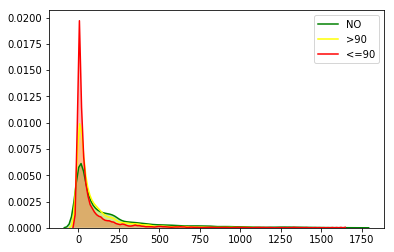

In [55]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == 'NO']['interval_prev_all'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '>90']['interval_prev_all'], color = 'yellow', shade = True, label = '>90')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '<=90']['interval_prev_all'], color = 'red', shade = True, label = '<=90')

### Interval since last visit (IP)

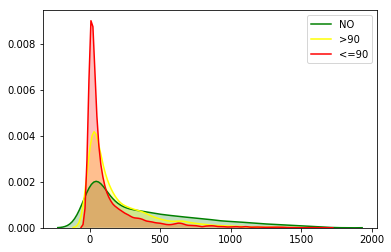

In [56]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == 'NO']['interval_prev'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '>90']['interval_prev'], color = 'yellow', shade = True, label = '>90')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '<=90']['interval_prev'], color = 'red', shade = True, label = '<=90')

### Interval till next admission (IP)

In [57]:
#sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == 'NO']['interval_next'], color = 'green', shade = True, label = 'NO')
#sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '>30']['interval_next'], color = 'yellow', shade = True, label = '>30')
#sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient'] == '<=30']['interval_next'], color = 'red', shade = True, label = '<=30')

### Past ER visits (last 12 months)

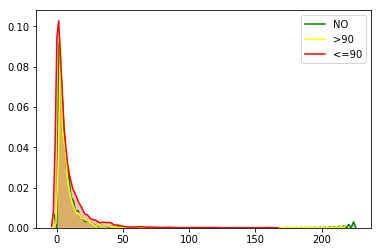

In [58]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == 'NO']['past_visits_ER'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '>90']['past_visits_ER'], color = 'yellow', shade = True, label = '>90')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '<=90']['past_visits_ER'], color = 'red', shade = True, label = '<=90')

### Past Inpatient visits (last 12 months)

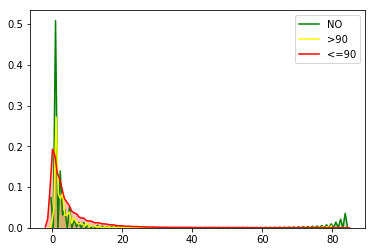

In [59]:
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == 'NO']['past_visits_IP'], color = 'green', shade = True, label = 'NO')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '>90']['past_visits_IP'], color = 'yellow', shade = True, label = '>90')
sns.kdeplot(readmission_ip[readmission_ip['Future_Inpatient_90'] == '<=90']['past_visits_IP'], color = 'red', shade = True, label = '<=90')

### Transfer in from ER

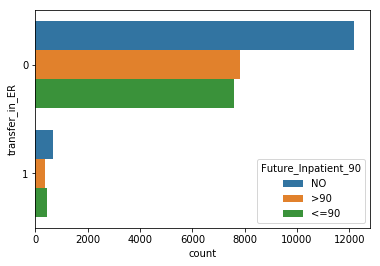

In [60]:
sns.countplot(y = 'transfer_in_ER', hue = 'Future_Inpatient_90', data = readmission_ip)

### Transfer in from IP

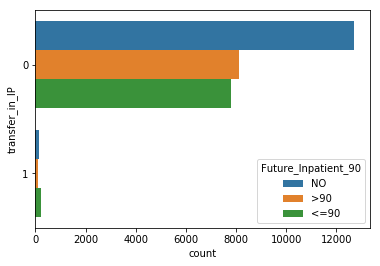

In [61]:
sns.countplot(y = 'transfer_in_IP', hue = 'Future_Inpatient_90', data = readmission_ip)

### CCS10 Category

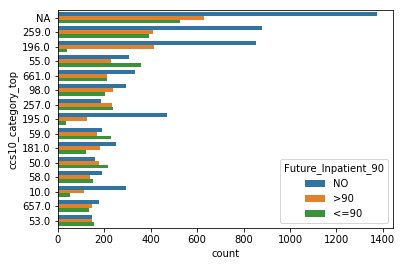

In [62]:
sns.countplot(y = 'ccs10_category_top', hue = 'Future_Inpatient_90', data = readmission_ip, order=readmission_ip['ccs10_category_top'].value_counts().iloc[:15].index)

## Classifier

In [63]:
readmission_ip.dtypes

person_id                                 object
Age_at_visit                               int64
patient_city                              object
patient_county                            object
patient_zipcode                            int64
hospital_poc                              object
Hospital_visit_date               datetime64[ns]
discharge_date                    datetime64[ns]
encounter_type                            object
payor_name                                object
last community care location              object
last community care visit date    datetime64[ns]
ethnicity                                 object
language                                  object
uds ethnicity                             object
uds race                                  object
uds homless                               object
LACE L score                               int64
LACE A score                               int64
LACE E score                               int64
Total LACE score    

### Exclude Transfer Admission (TA)

In [48]:
readmission_ip = readmission_ip[readmission_ip.transfer_out_IP == 0]

### Select features

In [51]:
readmission_ip_model = readmission_ip[['Age_at_visit','patient_city','patient_county','hospital_poc','payor_name','last community care location','ethnicity','language','uds ethnicity','uds race','uds homless','LACE L score','LACE A score','LACE E score','Total LACE score','transfer_in_ER','transfer_in_IP','interval_prev','interval_prev_all','past_visits_ER','past_visits_IP','income','education','poverty','ccs10_category_top','Future_Inpatient_90']]

In [52]:
readmission_ip_model = readmission_ip_model[readmission_ip_model.patient_city == 'Austin']

In [53]:
readmission_ip_model.dtypes

Age_at_visit                      int64
patient_city                     object
patient_county                   object
hospital_poc                     object
payor_name                       object
last community care location     object
ethnicity                        object
language                         object
uds ethnicity                    object
uds race                         object
uds homless                      object
LACE L score                      int64
LACE A score                      int64
LACE E score                      int64
Total LACE score                  int64
transfer_in_ER                    int64
transfer_in_IP                    int64
interval_prev                   float64
interval_prev_all               float64
past_visits_ER                  float64
past_visits_IP                  float64
income                           object
education                        object
poverty                          object
ccs10_category_top               object


In [56]:
readmission_ip_model['income'] = readmission_ip_model.income.apply(lambda x: np.nan if x == 'NA' else x)
readmission_ip_model['education'] = readmission_ip_model.education.apply(lambda x: np.nan if x == 'NA' else x)
readmission_ip_model['poverty'] = readmission_ip_model.poverty.apply(lambda x: np.nan if x == 'NA' else x)

In [57]:
def get_transfer(transfer):
    if transfer == 0:
        return 'No'
    else:
        return 'Yes'

In [58]:
readmission_ip_model['transfer_in_ER'] = readmission_ip_model.transfer_in_ER.apply(get_transfer)
readmission_ip_model['transfer_in_IP'] = readmission_ip_model.transfer_in_ER.apply(get_transfer)

In [59]:
#readmission_ip_model['Age_at_visit'] = readmission_ip_model['Age_at_visit'].apply(lambda x: np.nan if x == 0 else x)

In [60]:
num = readmission_ip_model.select_dtypes(include=[int64, float64]).columns.values.tolist()
cat = readmission_ip_model.select_dtypes(include=[object]).drop('Future_Inpatient_90',axis=1).columns.values.tolist()

In [61]:
num

['Age_at_visit',
 'LACE L score',
 'LACE A score',
 'LACE E score',
 'Total LACE score',
 'interval_prev',
 'interval_prev_all',
 'past_visits_ER',
 'past_visits_IP',
 'income',
 'education',
 'poverty']

In [62]:
cat

['patient_city',
 'patient_county',
 'hospital_poc',
 'payor_name',
 'last community care location',
 'ethnicity',
 'language',
 'uds ethnicity',
 'uds race',
 'uds homless',
 'transfer_in_ER',
 'transfer_in_IP',
 'ccs10_category_top']

In [63]:
readmission_ip_model[num].apply(lambda x: x.isnull().sum())

Age_at_visit            0
LACE L score            0
LACE A score            0
LACE E score            0
Total LACE score        0
interval_prev        9856
interval_prev_all    3092
past_visits_ER          0
past_visits_IP          0
income                364
education             364
poverty               364
dtype: int64

### Feature transformation and Train-test split

In [68]:
imputer = Imputer()
X_num_wnull = imputer.fit_transform(readmission_ip_model[['interval_prev','interval_prev_all','income','education','poverty']])

In [69]:
encoder = OneHotEncoder()
le = LabelEncoder()

X_num_wonull = np.array(readmission_ip_model[['Age_at_visit','LACE L score', 'LACE A score', 'LACE E score', 'Total LACE score','past_visits_ER','past_visits_IP']])
X_cat = readmission_ip_model[cat].astype(str).apply(le.fit_transform)
X_cat = encoder.fit_transform(X_cat).toarray()
#X_nl = np.concatenate((X_num_wonull, X_num_wnull), axis = 1)
X_nl = np.concatenate((X_num_wonull, X_num_wnull, X_cat), axis = 1)

y = readmission_ip_model.Future_Inpatient_90.apply(lambda x: 1 if x =='<=90' else 0)

X_train, X_test, y_train, y_test = train_test_split(X_nl, y, test_size=0.3, random_state=24)

X_train_num, X_train_cat = X_train[:,:11], X_train[:,11:]
X_test_num, X_test_cat = X_test[:,:11], X_test[:,11:]

In [70]:
#get names for cat features
cat_list = []
for c in cat:
    values = sorted(set(readmission_ip_model[c].astype(str).values.tolist()))
    for v in values:
        cat_list.append('{}_{}'.format(c,v))   

#col_names =['Age_at_visit','LACE L score', 'LACE A score', 'LACE E score', 'Total LACE score','past_visits_ER','past_visits_IP'] + ['interval','income']
col_names =['Age_at_visit','LACE L score', 'LACE A score', 'LACE E score', 'Total LACE score','past_visits_ER','past_visits_IP'] + ['interval_prev','interval_prev_all','income','education','poverty'] + cat_list
X_features_nl = pd.DataFrame(X_nl, columns=col_names)
X_features_nl_train = pd.DataFrame(X_train, columns=col_names)
X_features_nl_test = pd.DataFrame(X_test, columns=col_names)

In [71]:
X_features_nl.shape

(22167, 423)

In [72]:
X_features_nl_train.shape

(15516, 423)

In [73]:
X_features_nl.head()

,Age_at_visit,LACE L score,LACE A score,LACE E score,Total LACE score,past_visits_ER,past_visits_IP,interval_prev,interval_prev_all,income,...,ccs10_category_top_91.0,ccs10_category_top_92.0,ccs10_category_top_93.0,ccs10_category_top_94.0,ccs10_category_top_95.0,ccs10_category_top_96.0,ccs10_category_top_97.0,ccs10_category_top_98.0,ccs10_category_top_99.0,ccs10_category_top_NA
0,36.0,0.0,0.0,1.0,1.0,0.0,0.0,237.644464,132.362726,56819.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.0,0.0,3.0,2.0,5.0,0.0,0.0,237.644464,132.362726,43871.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53.0,1.0,3.0,4.0,8.0,4.0,0.0,237.644464,4.000000,47244.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,23.0,3.0,3.0,1.0,7.0,3.0,0.0,237.644464,180.000000,34950.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24.0,0.0,3.0,1.0,4.0,4.0,1.0,393.000000,201.000000,34950.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Baseline

In [74]:
baseline = y_test.value_counts()[1]*1.0/len(y_test)
baseline

0.26341903473161932

### Tree-based model

### Random Forest

In [85]:
clf_rf = RandomForestClassifier()
n_estimators = [10, 50, 100, 200, 500]
max_features = ['sqrt', 'log2']
param_grid = dict(n_estimators=n_estimators, max_features = max_features)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
grid_search_rf = GridSearchCV(clf_rf, param_grid, n_jobs=-1,scoring="roc_auc", cv=kfold)
grid_search_rf.fit(X_train, y_train)
result_rf = grid_search_rf.cv_results_

In [86]:
mean_test_score_rf = result_rf['mean_test_score']

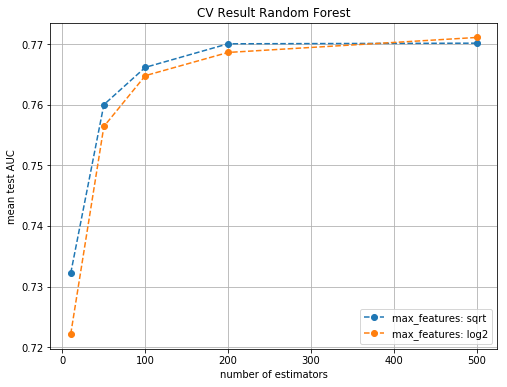

In [87]:
mean_test_score_rf = mean_test_score_rf.reshape(len(max_features),len(n_estimators))
plt.figure(figsize=(8,6))
for i, score in enumerate(mean_test_score_rf):
    plt.plot(n_estimators,mean_test_score_rf[i,], '--',marker = 'o', label = 'max_features: %s'%(max_features[i]))
plt.xlabel('number of estimators')
plt.ylabel('mean test AUC')
plt.title('CV Result Random Forest')
plt.legend()
plt.grid(True)

In [88]:
clf_rf = RandomForestClassifier(n_estimators=500, max_features = 'sqrt')

start = time.time()
clf_rf.fit(X_train,y_train)
print ('Random Forest model fitting time: {}s'.format(time.time()-start))

y_pred_rf = clf_rf.predict(X_test)
y_pred_prob_rf = clf_rf.predict_proba(X_test)[:,1]

Random Forest model fitting time: 77.66486763954163s


In [89]:
accuracy_score(y_pred_rf, y_test)

0.78649827093670122

In [90]:
print(classification_report(y_test, y_pred_rf))

             precision    recall  f1-score   support

          0       0.80      0.94      0.87      4899
          1       0.68      0.35      0.46      1752

avg / total       0.77      0.79      0.76      6651



In [91]:
fimp_rf = zip(X_features_nl.columns.values.tolist(),clf_rf.feature_importances_.tolist())

In [92]:
sorted(fimp_rf, key = lambda x: x[1], reverse=True)[:20]

[('interval_prev', 0.08230705377752777),
 ('past_visits_IP', 0.08180278176728598),
 ('interval_prev_all', 0.06405102638839599),
 ('Age_at_visit', 0.056537388557879216),
 ('Total LACE score', 0.04653478940414015),
 ('past_visits_ER', 0.04556421899143117),
 ('education', 0.03440654190438109),
 ('income', 0.033365545879144),
 ('poverty', 0.032651460122881636),
 ('LACE L score', 0.031147443513975456),
 ('LACE E score', 0.02483359380999438),
 ('LACE A score', 0.010848849693544022),
 ('hospital_poc_Brackenridge Hospital', 0.010024065154601178),
 ('payor_name_Medicaid', 0.009094481479026924),
 ('hospital_poc_St. Davids Medical Center', 0.008020514008251958),
 ('payor_name_Medicare', 0.007870258938620072),
 ('last community care location_CUC North Central', 0.007850213041354658),
 ('uds homless_Not Homeless', 0.007642058021859735),
 ('ethnicity_Hispanic Or Latino', 0.0076157947104517135),
 ('ethnicity_Not Hispanic Or Latino', 0.007601776008285835)]

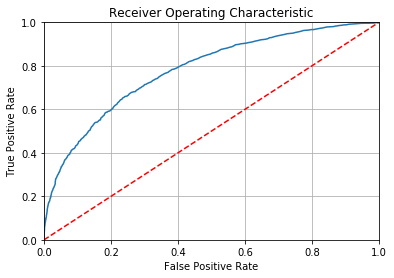

In [93]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid(True)

In [94]:
roc_auc_rf

0.78028160858473583

### XGBoost 

In [150]:
clf_xgb = XGBClassifier()
n_estimators = [10, 50, 100, 200, 500]
learning_rate = [0.001, 0.01, 0.1]
reg_lambda = [0.001, 0.01, 0.1, 1, 10]
# sub_sample = [0.1, 0.5, 1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators,reg_lambda = reg_lambda)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
grid_search_xgb = GridSearchCV(clf_xgb, param_grid, n_jobs = -1, scoring="roc_auc", cv=kfold)
grid_search_xgb.fit(X_train, y_train)
result_xgb = grid_search_xgb.cv_results_

In [151]:
mean_test_score_xgb = result_xgb['mean_test_score']

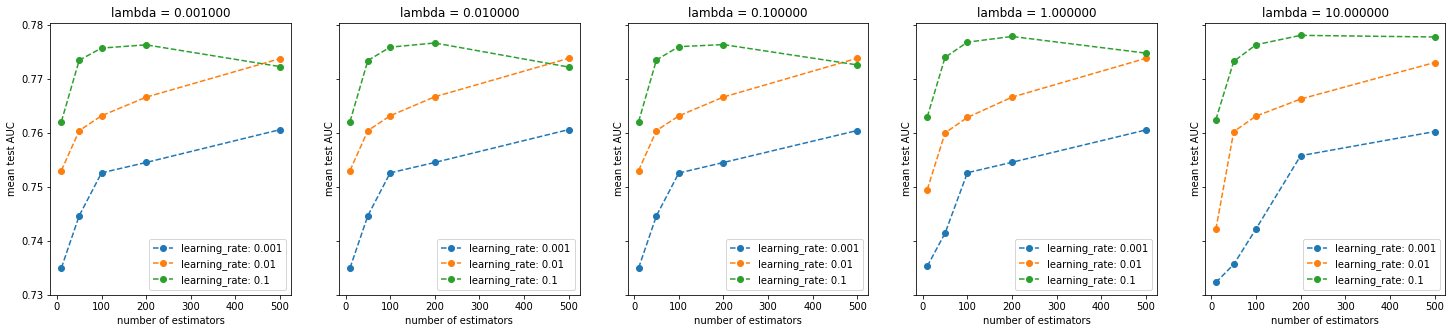

In [152]:
mean_test_score_xgb = np.swapaxes(np.swapaxes(mean_test_score_xgb.reshape(len(learning_rate), len(n_estimators), len(reg_lambda)),1,2),0,1)
fig, (ax1, ax2, ax3, ax4, ax5) = subplots(nrows=1,ncols=5,figsize=(25, 5), sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5]

for i, score in enumerate(mean_test_score_xgb):
    for j,s in enumerate(score):
        ax[i].plot(n_estimators, score[j,], '--',marker = 'o', label = 'learning_rate: %s'%(learning_rate[j]))
    ax[i].set_xlabel('number of estimators')
    ax[i].set_ylabel('mean test AUC')
    ax[i].set_title('lambda = %f'%reg_lambda[i])
    ax[i].legend()

In [153]:
clf_xgb = XGBClassifier(n_estimators=500, learning_rate = 0.1, reg_lambda = 10)
start = time.time()
clf_xgb.fit(X_train,y_train)
print ('XGBoost model fitting time: {}s'.format(time.time()-start))

y_pred_xgb = clf_xgb.predict(X_test)
y_pred_prob_xgb = clf_xgb.predict_proba(X_test)[:,1]

XGBoost model fitting time: 26.40901803970337s


In [154]:
fimp_xgb = zip(X_features_nl.columns.values.tolist(),clf_xgb.feature_importances_.tolist())

#### Get top 20 features

In [155]:
fimp_xgb_top = sorted(fimp_xgb, key = lambda x: x[1], reverse=True)[:20]

In [156]:
fimp_xgb_top

[('interval_prev', 0.08936323970556259),
 ('past_visits_ER', 0.06982634216547012),
 ('Age_at_visit', 0.06801736354827881),
 ('interval_prev_all', 0.06078147515654564),
 ('Total LACE score', 0.04413893073797226),
 ('past_visits_IP', 0.04377713426947594),
 ('income', 0.04232995584607124),
 ('education', 0.03690303862094879),
 ('LACE E score', 0.027134587988257408),
 ('LACE L score', 0.02206946536898613),
 ('ccs10_category_top_193.0', 0.018089724704623222),
 ('poverty', 0.017004340887069702),
 ('ccs10_category_top_192.0', 0.014471779577434063),
 ('ccs10_category_top_196.0', 0.013386396691203117),
 ('ccs10_category_top_185.0', 0.01157742366194725),
 ('ccs10_category_top_176.0', 0.010853835381567478),
 ('language_English', 0.010492040775716305),
 ('ccs10_category_top_134.0', 0.010492040775716305),
 ('hospital_poc_Brackenridge Hospital', 0.010130246169865131),
 ('ccs10_category_top_NA', 0.010130246169865131)]

In [157]:
cate_names = ['ccs10_category_top_193.0','ccs10_category_top_192.0',
              'ccs10_category_top_196.0','ccs10_category_top_185.0',
              'ccs10_category_top_176.0','language_English',
              'ccs10_category_top_134.0','hospital_poc_Brackenridge Hospital',
              'ccs10_category_top_NA']

In [158]:
features_top = [f for (f,imp) in fimp_xgb_top]

In [159]:
X_train_top = np.array(X_features_nl_train.loc[:,features_top])

In [160]:
X_test_top = np.array(X_features_nl_test.loc[:,features_top])

In [161]:
accuracy_score(y_pred_xgb, y_test, )

0.78304014433919711

In [162]:
print(classification_report(y_test, y_pred_xgb))

             precision    recall  f1-score   support

          0       0.80      0.94      0.86      4899
          1       0.67      0.35      0.46      1752

avg / total       0.77      0.78      0.76      6651



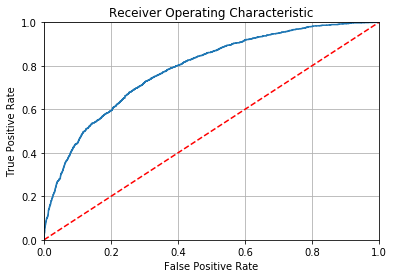

In [163]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid(True)

In [164]:
roc_auc_xgb

0.78645004665009444

### Logistic Regression

In [165]:
readmission_ip_model.interval_prev = readmission_ip_model.interval_prev.apply(lambda x:np.log10(x+0.1))
readmission_ip_model.interval_prev_all = readmission_ip_model.interval_prev_all.apply(lambda x:np.log10(x+0.1))
readmission_ip_model.past_visits_IP = readmission_ip_model.past_visits_IP.apply(lambda x:np.log10(x+0.1))
readmission_ip_model.past_visits_ER = readmission_ip_model.past_visits_ER.apply(lambda x:np.log10(x+0.1))

In [166]:
imputer = Imputer()
X_num_wnull = imputer.fit_transform(readmission_ip_model[['interval_prev','interval_prev_all','income','education','poverty']])

In [169]:
encoder = OneHotEncoder()
le = LabelEncoder()

X_num_wonull = np.array(readmission_ip_model[['Age_at_visit','LACE L score', 'LACE A score', 'LACE E score', 'Total LACE score','past_visits_ER','past_visits_IP']])
X_cat = readmission_ip_model[cat].astype(str).apply(le.fit_transform)
X_cat = encoder.fit_transform(X_cat).toarray()
X_l = np.concatenate((X_num_wonull, X_num_wnull, X_cat), axis = 1)

y = readmission_ip_model.Future_Inpatient_90.apply(lambda x: 1 if x =='<=90' else 0)

X_train, X_test, y_train, y_test = train_test_split(X_l, y, test_size=0.3, random_state=24)

X_train_num, X_train_cat = X_train[:,:11], X_train[:,11:]
X_test_num, X_test_cat = X_test[:,:11], X_test[:,11:]

In [170]:
cat_list = []
for c in cat:
    values = sorted(set(readmission_ip_model[c].astype(str).values.tolist()))
    for v in values:
        cat_list.append('{}_{}'.format(c,v))   

col_names =['Age_at_visit','LACE L score', 'LACE A score', 'LACE E score', 'Total LACE score','past_visits_ER','past_visits_IP'] + ['interval_prev','interval_prev_all','income','education','poverty'] + cat_list
X_features_l = pd.DataFrame(X_l, columns=col_names)

In [171]:
X_features_l.shape

(22167, 423)

In [172]:
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train)
X_test_lr = scaler.transform(X_test)

In [173]:
X_train_lr.shape

(15516, 423)

In [175]:
clf_lr = LogisticRegression()
C = [0.001, 0.01, 0.1, 1, 10]
penalty = ['l2','l1']
param_grid = dict(C = C, penalty = penalty)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
grid_search_lr = GridSearchCV(clf_lr, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_search_lr.fit(X_train_lr, y_train)
result_lr = grid_search_lr.cv_results_

In [176]:
mean_test_score_lr = np.transpose(result_lr['mean_test_score'].reshape(len(C), len(penalty)))

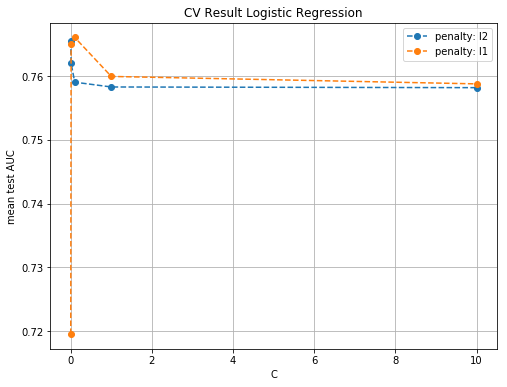

In [177]:
plt.figure(figsize=(8,6))
for i, score in enumerate(mean_test_score_lr):
    plt.plot(C, mean_test_score_lr[i,], '--',marker = 'o', label = 'penalty: %s'%(penalty[i]))
plt.xlabel('C')
plt.ylabel('mean test AUC')
plt.title('CV Result Logistic Regression')
plt.legend()
plt.grid(True)

In [178]:
clf_lr = LogisticRegression(penalty='l1', C = 0.01)
clf_lr.fit(X_train_lr,y_train)

y_pred_lr = clf_lr.predict(X_test_lr)
y_pred_prob_lr = clf_lr.predict_proba(X_test_lr)[:,1]

In [179]:
accuracy_score(y_pred_lr, y_test)

0.77176364456472712

In [180]:
print(classification_report(y_test, y_pred_lr))

             precision    recall  f1-score   support

          0       0.79      0.93      0.86      4899
          1       0.63      0.32      0.42      1752

avg / total       0.75      0.77      0.74      6651



In [181]:
lr_lasso = LogisticRegression(penalty='l1', C = 0.001) #high C to shrink coefs of variables to zero
lr_lasso.fit(X_train, y_train)
lr_coef = zip(X_features_l.columns.values.tolist(),lr_lasso.coef_[0].tolist())

In [182]:
pd.DataFrame(sorted([x for x in lr_coef if x[1] != 0], key = lambda x: x[1], reverse=True))

,0,1
0,past_visits_IP,0.266851
1,Total LACE score,0.105826
2,Age_at_visit,0.010473
3,income,-0.000012
4,education,-0.010037
5,poverty,-0.032126


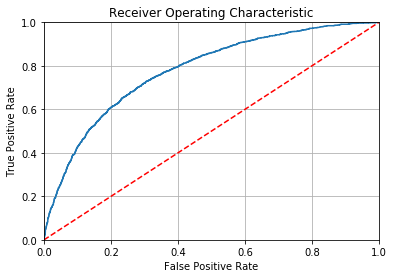

In [183]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_prob_lr)
    
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid(True)

In [184]:
roc_auc_lr

0.77868485647522889

### Neural Network

In [271]:
seed = 7
np.random.seed(seed)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
num_features = X_train.shape[1]

In [296]:
model = Sequential()

model.add(Dense(64, input_dim=num_features, kernel_initializer='normal', activation='relu',kernel_constraint=maxnorm(2), name = "Hidden_Layer1"))

model.add(Dropout(0.5, name = "Drop_Out_Layer1"))

model.add(Dense(32, kernel_initializer='normal', activation='relu',name = "Hidden_Layer0"))
model.add(Dropout(0.5, name = "Drop_Out_Layer2"))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid', name = "Output_Layer"))
optimizer = Nadam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.fit(X_train,y_train,batch_size = 100, epochs = 150, verbose = 1)

Epoch 1/150
15516/15516 [==============================] - 2s 130us/step - loss: 0.6616 - acc: 0.7020
Epoch 2/150
15516/15516 [==============================] - 1s 57us/step - loss: 0.6054 - acc: 0.7410
Epoch 3/150
15516/15516 [==============================] - 1s 55us/step - loss: 0.5648 - acc: 0.7412
Epoch 4/150
15516/15516 [==============================] - 1s 54us/step - loss: 0.5451 - acc: 0.7411
Epoch 5/150
15516/15516 [==============================] - 1s 52us/step - loss: 0.5341 - acc: 0.7412
Epoch 6/150
15516/15516 [==============================] - 1s 54us/step - loss: 0.5264 - acc: 0.7410
Epoch 7/150
15516/15516 [==============================] - 1s 53us/step - loss: 0.5174 - acc: 0.7416
Epoch 8/150
15516/15516 [==============================] - 1s 49us/step - loss: 0.5150 - acc: 0.7450
Epoch 9/150
15516/15516 [==============================] - 1s 47us/step - loss: 0.5089 - acc: 0.7474
Epoch 10/150
15516/15516 [==============================] - 1s 62us/step - loss: 0.5045 - 

In [297]:
y_pred_prob_nn = model.predict(X_test)
roc_auc_score(y_test,y_pedict_prob_nn)

0.761833907954377

### LACE Prediction

In [77]:
lace_test = np.array(X_features_nl_test['Total LACE score'])

In [79]:
lace_pred = np.where(lace_test >= 10, 1, 0)

In [90]:
accuracy_score(y_test,lace_pred)

0.73207036535859271

### ROC Curve

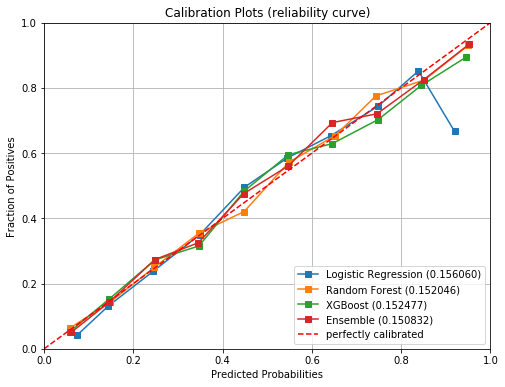

In [311]:
fraction_of_positives = dict()
mean_predicted_value = dict()
b_score = dict()
model = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Ensemble']
y_pred_prob = [y_pred_prob_lr, y_pred_prob_rf, y_pred_prob_xgb, y_pred_prob_ensemble]

plt.figure(figsize=(8,6))

for i in range(len(model)):
    fraction_of_positives[i], mean_predicted_value[i] = calibration_curve(y_test,y_pred_prob[i], n_bins=10)
    b_score[i] = brier_score_loss(y_test, y_pred_prob[i])
for i in range(len(model)):
    plt.plot(mean_predicted_value[i], fraction_of_positives[i], "s-", label = '%s (%f)'%(model[i],b_score[i]))
plt.plot([0, 1], [0, 1], 'r--', label = 'perfectly calibrated')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Predicted Probabilities')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plots (reliability curve)')
plt.legend(loc="lower right")
plt.grid(True)

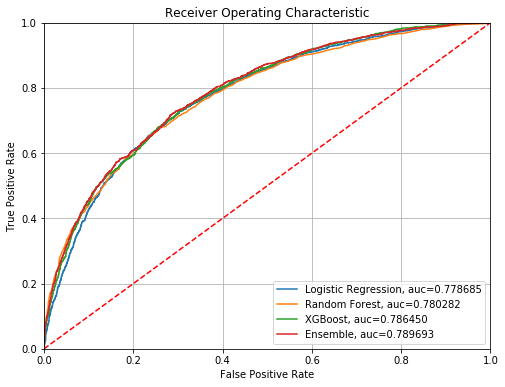

In [310]:
fpr = dict()
tpr = dict()
roc_auc = dict()
model = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Ensemble']
y_pred_prob = [y_pred_prob_lr, y_pred_prob_rf, y_pred_prob_xgb, y_pred_prob_ensemble]

plt.figure(figsize=(8,6))

for i in range(len(model)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob[i])
    roc_auc[i] = roc_auc_score(y_test, y_pred_prob[i])
    
for i in range(len(model)):
    plt.plot(fpr[i], tpr[i], label = '%s, auc=%f'%(model[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)

### Ensemble

In [188]:
rf_xgb_ensemble = []
roc_auc_ensemble = []

In [189]:
for p in np.linspace(start = 0, stop = 1, num = 101):
    pred_prob = p*y_pred_prob_rf + (1-p)*y_pred_prob_xgb
    roc = roc_auc_score(y_test, pred_prob)
    rf_xgb_ensemble.append(pred_prob)
    roc_auc_ensemble.append(roc)

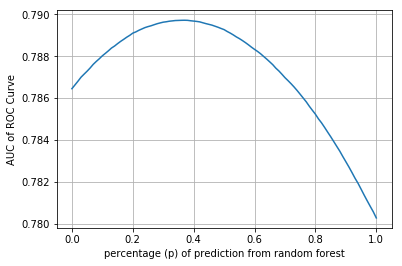

In [229]:
plt.plot(np.linspace(start = 0, stop = 1, num = 101), roc_auc_ensemble)
plt.xlabel('percentage (p) of prediction from random forest')
plt.ylabel('AUC of ROC Curve')
plt.grid(True)

In [191]:
roc_auc_ensemble.index(np.max(roc_auc_ensemble))

37

In [192]:
best_p = np.linspace(start = 0, stop = 1, num = 101)[39]

In [193]:
y_pred_prob_ensemble = best_p*y_pred_prob_rf + (1-best_p)*y_pred_prob_xgb

In [194]:
roc_auc_score(y_test,y_pred_prob_ensemble)

0.78969254278899514

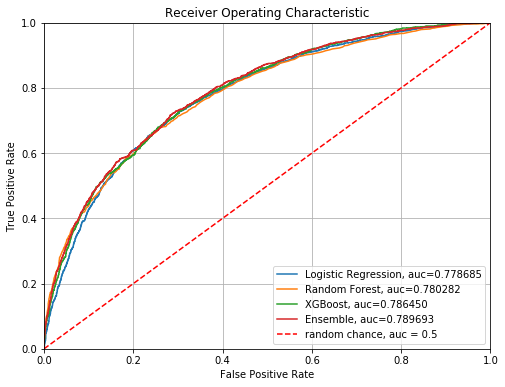

In [309]:
fpr = dict()
tpr = dict()
roc_auc = dict()
model = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Ensemble']
y_pred_prob = [y_pred_prob_lr, y_pred_prob_rf, y_pred_prob_xgb, y_pred_prob_ensemble]

plt.figure(figsize=(8,6))

for i in range(len(model)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob[i])
    roc_auc[i] = roc_auc_score(y_test, y_pred_prob[i])
    
for i in range(len(model)):
    plt.plot(fpr[i], tpr[i], label = '%s, auc=%f'%(model[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'r--', label = 'random chance, auc = 0.5')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)

### TOP FEATURES FROM XGBOOST

In [205]:
#X_train_top, X_test_top, y_train, y_test = train_test_split(X_top, y, test_size=0.3, random_state=24)
clf_xgb_top = XGBClassifier(n_estimators=300, learning_rate = 0.1, reg_lambda = 10)
start = time.time()
clf_xgb_top.fit(X_train_top,y_train)
print ('XGBoost model fitting time: {}s'.format(time.time()-start))

y_pred_xgb_top = clf_xgb_top.predict(X_test_top)
y_pred_prob_xgb_top = clf_xgb_top.predict_proba(X_test_top)[:,1]

XGBoost model fitting time: 3.2402515411376953s


In [206]:
accuracy_score(y_pred_xgb_top, y_test)

0.7812359043752819

In [207]:
print(classification_report(y_test, y_pred_xgb_top))

             precision    recall  f1-score   support

          0       0.80      0.94      0.86      4899
          1       0.66      0.34      0.45      1752

avg / total       0.76      0.78      0.75      6651



In [209]:
roc_auc_score(y_test, y_pred_prob_xgb_top)

0.78268879540228598

### <font color='green'>L</font> <font color='yellow'>I</font> <font color='green'>M</font> <font color='green'>E</font>

In [225]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import lime.lime_tabular
from __future__ import print_function

In [211]:
predict_fn_xgb = lambda x: clf_xgb_top.predict_proba(x).astype(float)

In [212]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_top, feature_names=features_top, categorical_features= [10,12,13,14,15,16,17,18,19], categorical_names=cate_names, class_names = ['No','Yes'])

In [232]:
obs = 3017

In [244]:
exp = explainer.explain_instance(X_test_top[obs], predict_fn_xgb, num_features=10)
exp.save_to_file('test.html')

In [242]:
obs2 = 4444

In [245]:
exp2 = explainer.explain_instance(X_test_top[obs2], predict_fn_xgb, num_features=10)
exp2.save_to_file('test2.html')

## Find Threshold

In [80]:
cost_medicare, cost_medicaid, cost_private, cost_uninsured = 13800, 12300, 14200, 10100
p_medicare, p_medicaid, p_private, p_uninsured = 0.31, 0.17, 0.38, 0.14
cost_readmission = cost_medicare*p_medicare + cost_medicaid*p_medicaid + cost_private*p_private + cost_uninsured*p_uninsured

In [81]:
cost_readmission

13179.0

In [82]:
cost_follow = 600

In [83]:
TP_saving = cost_readmission*0.2
FP_saving = -1*cost_follow
thresh = -FP_saving*1.0/(TP_saving-FP_saving)
print ("threshold = {}".format(thresh))

threshold = 0.18542555164101612


### the cost-saving optimal threshold is estimated to be 0.1854255516410161

In [298]:
#use threshold to find prediction
xgb_pred = np.where(y_pred_prob_xgb < thresh, 0, 1)
rf_pred = np.where(y_pred_prob_rf < thresh, 0, 1)
lr_pred = np.where(y_pred_prob_lr < thresh, 0, 1)
ensemble_pred = np.where(y_pred_prob_ensemble < thresh, 0, 1)

In [86]:
#define function to calculate cost saving
def cal_saving(tp, fp, tp_s, fp_s):
    saving = tp*tp_s + fp*fp_s
    return saving

In [300]:
#get confusion matrix
xgb_conf = confusion_matrix(y_test, xgb_pred)
rf_conf = confusion_matrix(y_test, rf_pred)
lr_conf = confusion_matrix(y_test, lr_pred)
ensemble_conf = confusion_matrix(y_test, ensemble_pred)
lace_conf = confusion_matrix(y_test, lace_pred) #use LACE prediction to benchmark

In [301]:
conf = [xgb_conf, rf_conf, lr_conf, ensemble_conf]
model_s = ['XGBoost', 'Random Forest','Logistic Regression', 'Ensemble(RF+XGB)']

savings = []
for c in conf:
    saving = cal_saving(c[1][1], c[0][1], TP_saving, FP_saving)
    savings.append(saving)

In [88]:
#bench mark saving from LACE
cal_saving(lace_conf[1][1], lace_conf[0][1], TP_saving, FP_saving)

747460.80000000005

In [304]:
saving_df = pd.DataFrame({'Model':model_s, 'Savings': savings})
saving_df['Savings(per 1000 encounters)'] = saving_df.Savings.apply(lambda x: x/(len(y_test)/1000))
saving_df.Savings = saving_df.Savings.map('${:,.2f}'.format)
saving_df['Savings(per 1000 encounters)'] = saving_df['Savings(per 1000 encounters)'].map('${:,.2f}'.format)
saving_df.sort_values('Savings', ascending=False)

,Model,Savings,Savings(per 1000 encounters)
3,Ensemble(RF+XGB),"$2,567,952.00","$386,100.14"
0,XGBoost,"$2,525,092.80","$379,656.11"
2,Logistic Regression,"$2,519,802.60","$378,860.71"
1,Random Forest,"$2,503,131.00","$376,354.08"


In [303]:
y_test.value_counts()

0    4899
1    1752
Name: Future_Inpatient_90, dtype: int64

## Less than 30-Day Readmission 

### Oversampling minority class (<=30)

In [469]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [470]:
y = readmission_ip_model.Future_Inpatient.apply(lambda x: 1 if x =='<=30' else 0)

X_train, X_test, y_train, y_test = train_test_split(X_nl, y, test_size=0.3, random_state=24)

# X_train_num, X_train_cat = X_train[:,:11], X_train[:,11:]
# X_test_num, X_test_cat = X_test[:,:11], X_test[:,11:]

In [471]:
baseline = y_test.value_counts()[1]*1.0/len(y_test)
baseline

0.17369549678341673

In [472]:
X_resampled, y_resampled = SMOTE(ratio = 'minority', random_state = 24).fit_sample(X_train, y_train)

In [473]:
print(sorted(Counter(y_resampled).items()))

[(0, 10809), (1, 10809)]


### XGBoost

### Original Dataset (without resampling)

In [474]:
clf_xgb = XGBClassifier(n_estimators=500, learning_rate = 0.1, reg_lambda = 10)
start = time.time()
clf_xgb.fit(X_train,y_train)
print ('XGBoost model fitting time: {}s'.format(time.time()-start))

y_pred_xgb = clf_xgb.predict(X_test)
y_pred_prob_xgb = clf_xgb.predict_proba(X_test)[:,1]

XGBoost model fitting time: 36.4078004360199s


In [475]:
accuracy_score(y_pred_xgb, y_test)

0.8420300214438885

In [476]:
print(classification_report(y_test, y_pred_xgb))

             precision    recall  f1-score   support

          0       0.85      0.98      0.91      4624
          1       0.66      0.19      0.30       972

avg / total       0.82      0.84      0.80      5596



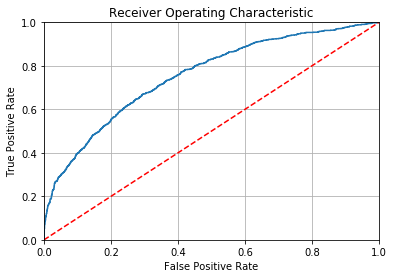

In [477]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid(True)

In [478]:
roc_auc_xgb

0.75453473646175961

### Oversampled Dataset

In [117]:
clf_xgb = XGBClassifier()
n_estimators = [10, 50, 100, 150, 200]
learning_rate = [0.001, 0.01, 0.1]
reg_lambda = [0.001, 0.01, 0.1, 1, 10]
# sub_sample = [0.1, 0.5, 1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators,reg_lambda = reg_lambda)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)
grid_search_xgb = GridSearchCV(clf_xgb, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)
grid_search_xgb.fit(X_resampled, y_resampled)
result_xgb = grid_search_xgb.cv_results_

In [118]:
mean_test_score_xgb = result_xgb['mean_test_score']

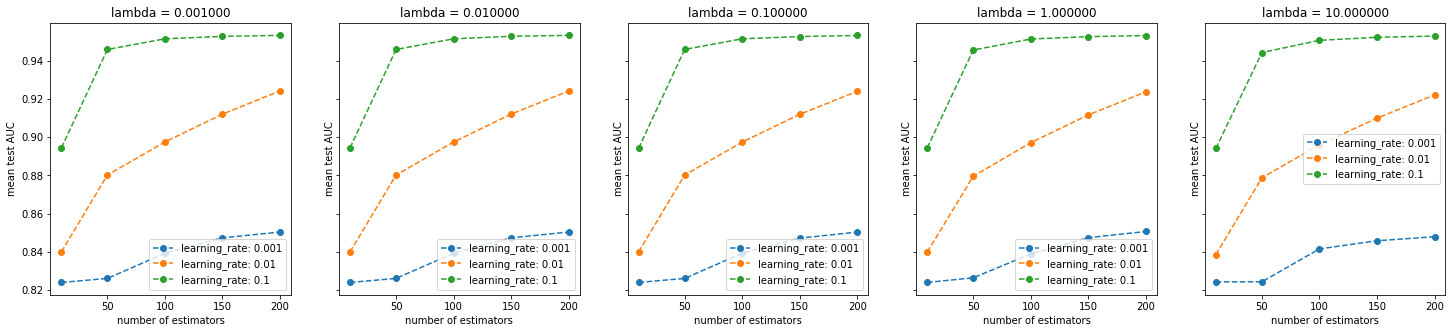

In [119]:
mean_test_score_xgb = np.swapaxes(np.swapaxes(mean_test_score_xgb.reshape(len(learning_rate), len(n_estimators), len(reg_lambda)),1,2),0,1)
fig, (ax1, ax2, ax3, ax4, ax5) = subplots(nrows=1,ncols=5,figsize=(25, 5), sharey=True)
ax = [ax1, ax2, ax3, ax4, ax5]

for i, score in enumerate(mean_test_score_xgb):
    for j,s in enumerate(score):
        ax[i].plot(n_estimators, score[j,], '--',marker = 'o', label = 'learning_rate: %s'%(learning_rate[j]))
    ax[i].set_xlabel('number of estimators')
    ax[i].set_ylabel('mean test AUC')
    ax[i].set_title('lambda = %f'%reg_lambda[i])
    ax[i].legend()

In [479]:
clf_xgb_rs = XGBClassifier(n_estimators=200, learning_rate = 0.1, reg_lambda = 0.01)
start = time.time()
clf_xgb_rs.fit(X_resampled,y_resampled)
print ('XGBoost model fitting time: {}s'.format(time.time()-start))

y_pred_xgb_rs = clf_xgb_rs.predict(X_test)
y_pred_prob_xgb_rs = clf_xgb_rs.predict_proba(X_test)[:,1]

XGBoost model fitting time: 22.862205982208252s


In [480]:
accuracy_score(y_pred_xgb_rs, y_test)

0.83934953538241597

In [481]:
print(classification_report(y_test, y_pred_xgb_rs))

             precision    recall  f1-score   support

          0       0.86      0.96      0.91      4624
          1       0.58      0.27      0.36       972

avg / total       0.81      0.84      0.81      5596



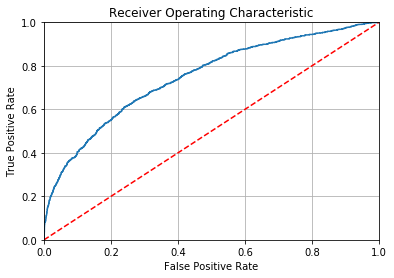

In [482]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb_rs)
roc_auc_xgb_rs = roc_auc_score(y_test, y_pred_prob_xgb_rs)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid(True)

In [483]:
roc_auc_xgb_rs

0.74855935929201023